In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#CICIDS2017:

## Subtask1 pre-processing

In [ ]:
#reading datafiles
import pandas as pd
df1 = pd.read_csv('gdrive/MyDrive/sem2/NS dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('gdrive/MyDrive/sem2/NS dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('gdrive/MyDrive/sem2/NS dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv')

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)


(225745, 79)
(286467, 79)
(191033, 79)


In [ ]:
#concatenate three data frames
df_c = pd.concat([df1,df2,df3])

In [ ]:
#dropping unnecessary columns
df_c.drop(' Destination Port', axis=1, inplace=True)

In [ ]:
d = df_c.dtypes.to_dict()
print("non numeric value in d1")
for col_name in d:
    if( d[col_name] == "object" ):
        print(col_name)

non numeric value in d1
 Label


In [ ]:
print("in df_c")
for cols in df_c.columns:
    if( cols == " Label" ):
        continue
    a = pd.to_numeric(df_c[cols], errors='ignore')#converts values into numeric, '1.0' to 1.0 and 'abc' and np.inf to NaN
    idx = a.isna()
    x = df_c[idx][cols]
    if( x.empty == False ):
        print(cols," -> ",df_c[idx][cols])


in df_c
Flow Bytes/s  ->  6796     NaN
14739    NaN
15047    NaN
209728   NaN
12824    NaN
12827    NaN
14192    NaN
40707    NaN
52456    NaN
56603    NaN
76549    NaN
76773    NaN
225846   NaN
237968   NaN
238016   NaN
239586   NaN
253214   NaN
259076   NaN
259682   NaN
10832    NaN
20901    NaN
23789    NaN
26374    NaN
34541    NaN
36102    NaN
36883    NaN
39729    NaN
49812    NaN
57793    NaN
63707    NaN
70816    NaN
87757    NaN
107340   NaN
120282   NaN
122940   NaN
126281   NaN
126402   NaN
130158   NaN
131386   NaN
131841   NaN
131982   NaN
135275   NaN
158875   NaN
164857   NaN
171777   NaN
180400   NaN
189205   NaN
Name: Flow Bytes/s, dtype: float64


In [ ]:
#replacing infinte to Nan, then will replace Nan with mode/mean
import numpy as np
df_c.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Drop the columns which have more than 25% NaN or NULL values
perc = 25.0
min_count =  int(((100-perc)/100)*df_c.shape[0] + 1)
df_c.dropna( axis=1, thresh=min_count, inplace=True)
print(df_c.shape)

(703245, 78)


In [ ]:
# replace NaN/NULL values in other columns with the average( or most repetitive) value of the corresponding column.
for cols in df_c.columns:
    if( cols == " Label" ):
        continue
    df_c[cols] = df_c[cols].fillna(df_c[cols].mean())

#prints the columsn having atlest one NaN
for cols in df_c.columns:
    if( cols == " Label" ):
        continue
    if( df_c[cols].isnull().values.any() == True):
        print( cols )

In [ ]:
print("before",df_c.shape)
cols = list(df_c.columns)
cols.remove(" Label")
df_c.drop_duplicates(subset = cols, inplace=True,  keep='first')
print("After",df_c.shape)

before (703245, 78)
After (507333, 78)


In [ ]:
# Replace all the attack labels with label ‘1’ and benign/no-attack sample labels with label ‘0’.

df_c.loc[df_c[" Label"] == "BENIGN", " Label"] = 0
df_c.loc[df_c[" Label"] != 0, " Label"] = 1

In [ ]:
#checking unique values before replacing values of label column
print(df_c[" Label"].unique())

[0 1]


In [ ]:
df_c[' Label'].value_counts()

0    375924
1    131409
Name:  Label, dtype: int64

In [ ]:
df_c.shape

(507333, 78)

In [ ]:
X = df_c.iloc[:,:-1]
Y = df_c.iloc[:,-1:]

## SubTask2 and subtask3

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import time
from sklearn.linear_model import LogisticRegression
!pip install decision-tree-id3
!pip install mlrose
import six
import sys
import time
sys.modules['sklearn.externals.six'] = six
import mlrose
from id3 import Id3Estimator
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
'''
takes takes datapoints, labels and k value for selectKBest features, do normalize the data, apply selectKBest feature seclection method, Then fitting all 9 models on this data
and Create the confusion matrix for each model (with the test data), sketch a single table containing accuracy, precision, recall, f1-score, and running time(s) comparison among
all the models Plot the AUC-ROC curve for all the models
'''
def select_k_result(k, X, Y):

  scaler = MinMaxScaler()
  X_std = scaler.fit_transform(X)
  Y = Y.astype('int')
  X_new = SelectKBest(chi2, k=k).fit_transform(X_std, Y)
  X_new.shape

  f_train_x, f_test_x, f_train_y, f_test_y = train_test_split(X_new, Y, test_size=0.20)

  print('Gaussian')
  nb = GaussianNB()
  start1 = time.time()
  nb.fit(f_train_x, f_train_y.values.ravel())
  end1 = time.time()

  f_predict_test = nb.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc1 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc2)
  ps1 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps2)
  re1 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re2)
  f11 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f12)
  tot_time1 = end1 - start1
  #print("Fitting time is ", tot_time2)


  print('Logistic Regression')
  logreg = LogisticRegression(max_iter=400000)
  start2 = time.time()
  logreg.fit(f_train_x,f_train_y.values.ravel())
  end2 = time.time()

  f_predict_test = logreg.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc2 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc3)
  ps2 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps3)
  re2 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re3)
  f12 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f13)
  tot_time2 = end2 - start2
  #print("Fitting time is ", tot_time3)

  print('RFC')
  rfc = RandomForestClassifier()
  start3 = time.time()
  rfc.fit(f_train_x, f_train_y.values.ravel())
  end3 = time.time()
  rfc.score(f_train_x,f_train_y.values.ravel())

  f_predict_test = rfc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc3 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc5)
  ps3 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps5)
  re3 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re5)
  f13 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f15)
  tot_time3 = end3 - start3
  #print("Fitting time is ", tot_time5)

  print('XGB')
  model = XGBClassifier()
  start4 = time.time()
  model.fit(f_train_x, f_train_y.values.ravel())
  end4 = time.time()
  y_pred = model.predict(f_test_x)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(f_test_y.values.ravel(), predictions)
  #print(accuracy)

  f_predict_test = model.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc4 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc6)
  ps4 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps6)
  re4 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re6)
  f14 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f16)
  tot_time4 = end4 - start4
  #print("Fitting time is ", tot_time6)


  print('ADC')
  adc = AdaBoostClassifier(n_estimators=141)
  start5 = time.time()
  adc.fit(f_train_x, f_train_y.values.ravel())
  end5 = time.time()
  adc.score(f_test_x, f_test_y.values.ravel())

  f_predict_test = adc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc5 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc8)
  ps5 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps8)
  re5 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re8)
  f15 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f18)
  tot_time5 = end5 - start5
  #print("Fitting time is ", tot_time8)

  print('MLPC')
  classifier = MLPClassifier(hidden_layer_sizes=(100), max_iter=300)
  start6 = time.time()
  classifier.fit(f_train_x, f_train_y.values.ravel())
  end6 = time.time()
  classifier.score(f_test_x, f_test_y.values.ravel())

  f_predict_test = adc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc6 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc9)
  ps6 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps9)
  re6 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re9)
  f16 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f19)
  tot_time6 = end6 - start6
  #print("Fitting time is ", tot_time9)

  print('ID3')
  estimator = Id3Estimator()
  start7 = time.time()
  estimator.fit(f_train_x, f_train_y.values.ravel())
  end7 = time.time()
  f_predict_test = estimator.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc7 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc4)
  ps7 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps4)
  re7 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re4)
  f17 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f14)
  tot_time7 = end7 - start7
  #print("Fitting time is ", tot_time4)


  print('VC')
  vc1 = LogisticRegression()
  vc2 = GaussianNB()
  vc3 = LinearSVC()
  vc = VotingClassifier(estimators=[('lr', vc1), ('gnb', vc2), ('svc', vc3) ],voting='hard')
  start8 = time.time()
  vc.fit(f_train_x, f_train_y.values.ravel())
  end8 = time.time()

  f_predict_test = vc.predict(f_test_x)
  # _predict_proba_lr
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc8 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc7)
  ps8 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps7)
  re8 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re7)
  f18 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f17)
  tot_time8 = end8 - start8
  #print("Fitting time is ", tot_time7)



  print('SVC')
  svc_pca = LinearSVC()
  start9 = time.time()
  svc_pca.fit(f_train_x , f_train_y.values.ravel())
  end9 = time.time()
  #print(svc_pca.score(f_test_x, f_test_y.values.ravel()))
  f_predict_test = svc_pca.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc9 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc1)
  ps9 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps1)
  re9 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re1)
  f19 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f11)
  tot_time9 = end9 - start9
  #print("Fitting time is ", tot_time1)

  mydata = [
      ["Gaussian", acc1, ps1, re1, f11, tot_time1],
      ["Logistic Regression", acc2, ps2, re2, f12, tot_time2],
      ["RFC", acc3, ps3, re3, f13, tot_time3],
      ["XGB", acc4, ps4, re4, f14, tot_time4],
      ["ADC", acc5, ps5, re5, f15, tot_time5],
      ["MLPC", acc6, ps6, re6, f16, tot_time6],
      ["ID3", acc7, ps7, re7, f17, tot_time7],
      ["VC", acc8, ps8, re8, f18, tot_time8],
      ["SVC", acc9, ps9, re9, f19, tot_time9]
  ]

  # create header
  head = ["Accuracy", "Precision", "Recall", "F1-score", "Running time"]

  # display table
  print(tabulate(mydata, headers=head, tablefmt="grid"))

  f_predict_test = estimator.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='id3')
  display.plot()
  plt.show()

  y_pred_proba = nb.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = logreg.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


  y_pred_proba = rfc.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = model.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  f_predict_test = vc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='vc')
  display.plot()
  plt.show()

  y_pred_proba = adc.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = classifier.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='svc')
  display.plot()
  plt.show()

#### For unbalaced CICIDS2017, for selectbest k = 7, applying on all models

Gaussian 
[69914 5369 9998 16186]
Logistic Regression
[75146 137 10303 15881]
RFC
[72363 2920 288 25896]
XGB
[72391 2892 450 25734]
ADC
[72143 3140 501 25683]
MLPC
[72143 3140 501 25683]
ID3
[71837 3284 400 25946]
VC
[75200 286 10167 15814]
SVC
[74737 181 10423 16126]
+---------------------+------------+-------------+----------+------------+----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.848552 |    0.750916 | 0.618164 |   0.678104 |       0.217666 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.897109 |    0.991447 | 0.606515 |   0.752618 |       6.98986  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.968384 |    0.898667 | 0.989001 |   0.941673 |      60.5702

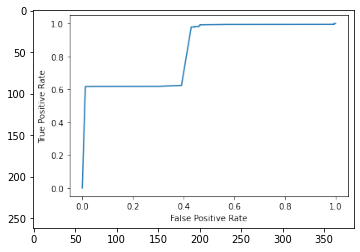

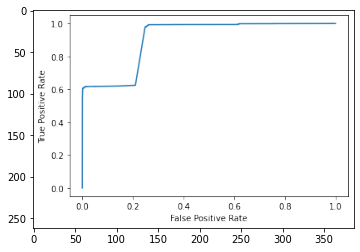

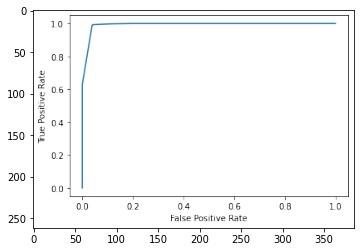

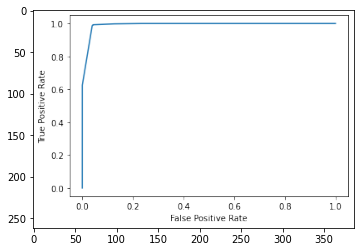

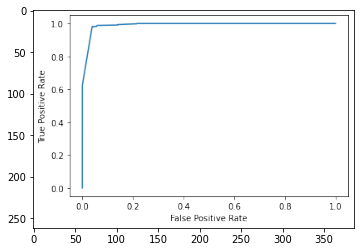

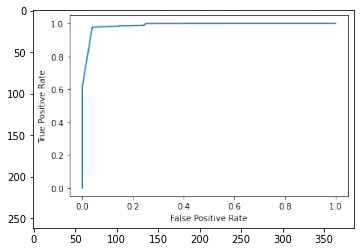

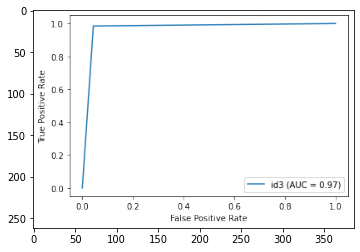

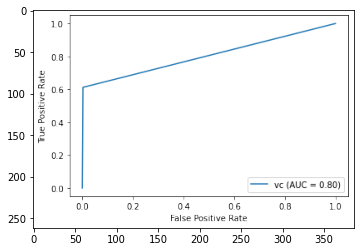

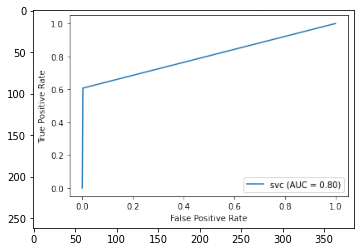

In [ ]:
select_k_result(7, X, Y)


#### For unbalaced CICIDS2017, for selectbest k = 8, applying on all models

Gaussian 
[69925  5330 10078 16134]
Logistic Regression
[75102   153 10375 15837]
RFC
[75189    66   281 25931]
XGB
[75179    76   340 25872]
ADC
[75048   207   704 25508]
MLPC
[75048   207   704 25508]
ID3
[75233    22   414 25798]
VC
[75097   158 10361 15851]
SVC
[75100   155 10419 15793]
+---------------------+------------+-------------+----------+------------+----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.848148 |    0.751677 | 0.618164 |   0.676819 |       0.104813 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.896242 |    0.990432 | 0.990432 |   0.750533 |       4.75863  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.99658  |    0.997461 | 0.98928  |   

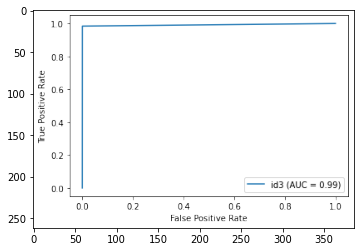

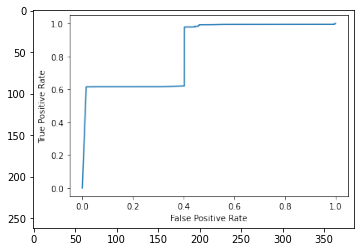

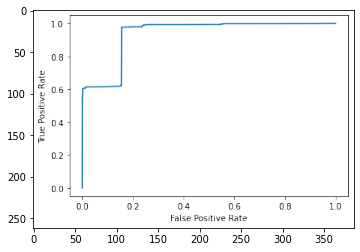

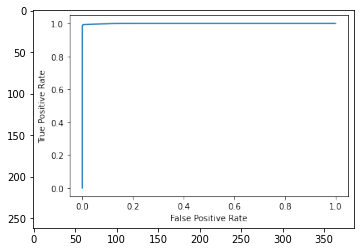

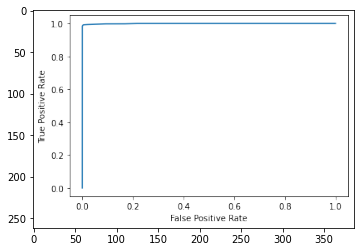

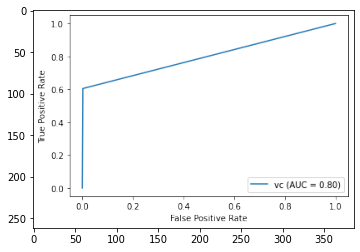

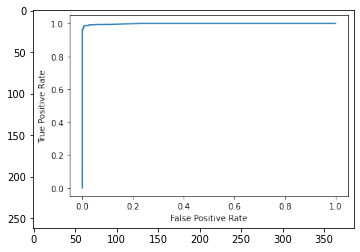

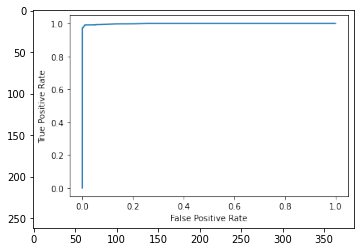

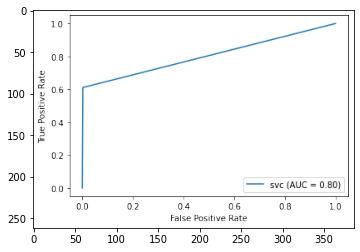

In [ ]:
select_k_result(8, X, Y)

#### For unbalaced CICIDS2017, for selectbest k = 9, applying on all models

Gaussian 
[69509  5738 10057 16163]
Logistic Regression
[75140   107 10362 15858]
RFC
[75190    57   276 25944]
XGB
[75188    59   276 25944]
ADC
[75053   194   686 25534]
MLPC
[75053   194   686 25534]
ID3
[75235    12   382 25838]
VC
[75120   127 10359 15861]
SVC
[75126   121 10388 15832]
+---------------------+------------+-------------+----------+------------+----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.844334 |    0.738003 | 0.616438 |   0.671765 |        0.33902 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.896824 |    0.993298 | 0.604805 |   0.751831 |        6.23414 |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.996718 |    0.997808 | 0.989474 |   

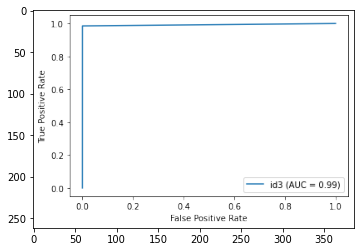

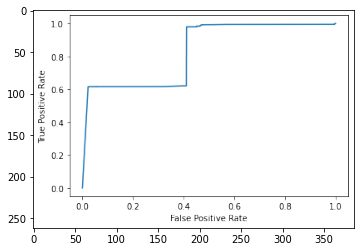

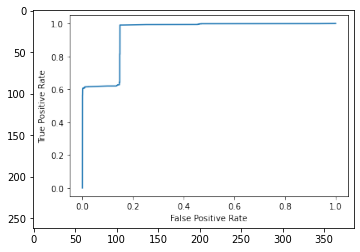

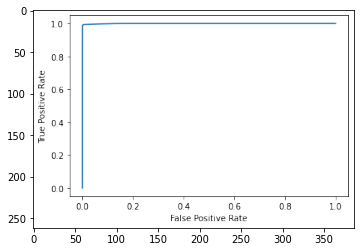

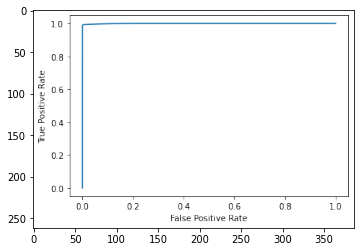

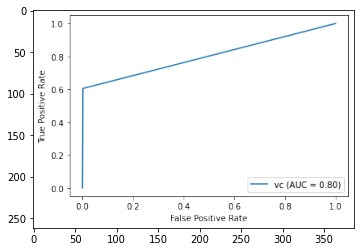

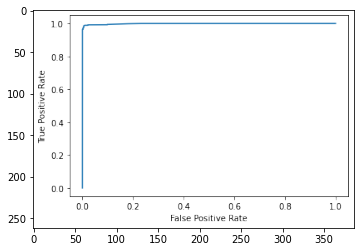

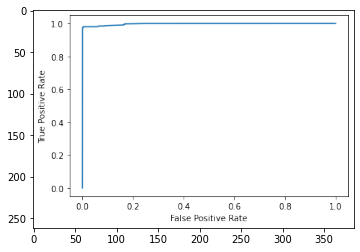

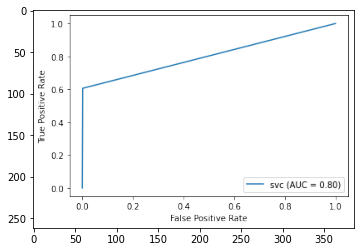

In [ ]:
select_k_result(9, X, Y)

In [ ]:
# sample
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# print("Gaussian \n[69914 5369 9998 16186]\nLogistic Regression\n[75146 137 10303 15881]\nRFC\n[72363 2920 288 25896]\nXGB\n[72391 2892 450 25734]\nADC\n[72143 3140 501 25683]\nMLPC\n[72143 3140 501 25683]\nID3\n[71837 3284 400 25946]\nVC\n[75200 286 10167 15814]\nSVC\n[74737 181 10423 16126]")
# mydata = [
# ["Gaussian" , 0.848552, 0.750916, 0.618164, 0.678104, 0.217666],
# ["Logistic Regression", 0.897109, 0.991447, 0.606515, 0.752618, 6.98986],
# ["RFC", 0.968384, 0.898667, 0.989001, 0.941673, 60.5702],
# ["XGB", 0.967063, 0.898973, 0.982814, 0.939026, 21.3863],
# ["ADC", 0.964116, 0.891059, 0.980866, 0.933808, 54.1292],
# ["MLPC", 0.964116, 0.891059, 0.980866, 0.933808, 1170.88],
# ["ID3" , 0.963693, 0.88765, 0.984817, 0.933712, 1128.19],
# ["VC", 0.896981, 0.982236, 0.608675, 0.751598, 16.2771],
# ["SVC",0.895493, 0.988900, 0.607405, 0.752567, 11.3591]
# ]

# # create header
# head = ["Model", "Accuracy", "Precision", "Recall", "F1-score", "Running time"]

# # display table
# print(tabulate(mydata, headers=head, tablefmt="grid"))

# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_Gaussian.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_Logreg.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_RFC.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_XGB.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_ADC.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_MLC.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_ID3.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_vc.png')
# imgplot = plt.imshow(img)
# plt.show()
# img = mpimg.imread('gdrive/MyDrive/cicids2017-20220313T140643Z-001/cicids2017/7_svc.png')
# imgplot = plt.imshow(img)
# plt.show()


#### Bonus part: using PCA, For unbalaced CICIDS2017, applying all models

In [ ]:
print(X.shape, Y.shape)

(507333, 77) (507333, 1)


In [ ]:
'''
it uses PCA for feature selection then works same as select-k-result function
'''

def show_pca_result(X, Y,df_c):
  scaler = MinMaxScaler()
  X_std = scaler.fit_transform(X)
  Y = Y.astype('int')

  pca = PCA(0.90)
  principalComponents = pca.fit_transform(X_std)
  principalDf = pd.DataFrame(data = principalComponents)
  # principalDf = principalDf.reset_index()
  # df_c = df_c.reset_index()
  f_train_x, f_test_x, f_train_y, f_test_y = train_test_split(principalDf, Y, test_size=0.20)
  f_test_y = f_test_y.astype('int')
  f_train_y = f_train_y.astype('int')
  print("pca components = ",pca.n_components_)

  print('Gaussian')
  nb = GaussianNB()
  start1 = time.time()
  nb.fit(f_train_x, f_train_y.values.ravel())
  end1 = time.time()

  f_predict_test = nb.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc1 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc2)
  ps1 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps2)
  re1 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re2)
  f11 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f12)
  tot_time1 = end1 - start1
  #print("Fitting time is ", tot_time2)


  print('Logistic Regression')
  logreg = LogisticRegression(max_iter=400000)
  start2 = time.time()
  logreg.fit(f_train_x,f_train_y.values.ravel())
  end2 = time.time()

  f_predict_test = logreg.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc2 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc3)
  ps2 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps3)
  re2 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re3)
  f12 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f13)
  tot_time2 = end2 - start2
  #print("Fitting time is ", tot_time3)

  print('RFC')
  rfc = RandomForestClassifier()
  start3 = time.time()
  rfc.fit(f_train_x, f_train_y.values.ravel())
  end3 = time.time()
  rfc.score(f_train_x,f_train_y.values.ravel())

  f_predict_test = rfc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc3 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc5)
  ps3 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps5)
  re3 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re5)
  f13 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f15)
  tot_time3 = end3 - start3
  #print("Fitting time is ", tot_time5)

  print('XGB')
  model = XGBClassifier()
  start4 = time.time()
  model.fit(f_train_x, f_train_y.values.ravel())
  end4 = time.time()
  y_pred = model.predict(f_test_x)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(f_test_y.values.ravel(), predictions)
  #print(accuracy)

  f_predict_test = model.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc4 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc6)
  ps4 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps6)
  re4 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re6)
  f14 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f16)
  tot_time4 = end4 - start4
  #print("Fitting time is ", tot_time6)


  print('ADC')
  adc = AdaBoostClassifier(n_estimators=141)
  start5 = time.time()
  adc.fit(f_train_x, f_train_y.values.ravel())
  end5 = time.time()
  adc.score(f_test_x, f_test_y.values.ravel())

  f_predict_test = adc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc5 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc8)
  ps5 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps8)
  re5 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re8)
  f15 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f18)
  tot_time5 = end5 - start5
  #print("Fitting time is ", tot_time8)

  print('MLPC')
  classifier = MLPClassifier(hidden_layer_sizes=(100), max_iter=300)
  start6 = time.time()
  classifier.fit(f_train_x, f_train_y.values.ravel())
  end6 = time.time()
  classifier.score(f_test_x, f_test_y.values.ravel())

  f_predict_test = adc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc6 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc9)
  ps6 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps9)
  re6 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re9)
  f16 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f19)
  tot_time6 = end6 - start6
  #print("Fitting time is ", tot_time9)

  print('ID3')
  estimator = Id3Estimator()
  start7 = time.time()
  estimator.fit(f_train_x, f_train_y.values.ravel())
  end7 = time.time()
  f_predict_test = estimator.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc7 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc4)
  ps7 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps4)
  re7 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re4)
  f17 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f14)
  tot_time7 = end7 - start7
  #print("Fitting time is ", tot_time4)


  print('VC')
  vc1 = LogisticRegression()
  vc2 = GaussianNB()
  vc3 = LinearSVC()
  vc = VotingClassifier(estimators=[('lr', vc1), ('gnb', vc2), ('svc', vc3) ],voting='hard')
  start8 = time.time()
  vc.fit(f_train_x, f_train_y.values.ravel())
  end8 = time.time()

  f_predict_test = vc.predict(f_test_x)
  # _predict_proba_lr
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc8 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc7)
  ps8 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps7)
  re8 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re7)
  f18 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f17)
  tot_time8 = end8 - start8
  #print("Fitting time is ", tot_time7)



  print('SVC')
  svc_pca = LinearSVC()
  start9 = time.time()
  svc_pca.fit(f_train_x , f_train_y.values.ravel())
  end9 = time.time()
  #print(svc_pca.score(f_test_x, f_test_y.values.ravel()))
  f_predict_test = svc_pca.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  cm1 = confusion_matrix(f_test_y.values.ravel(), f_predict_test).ravel()
  print(cm1)

  acc9 = accuracy_score(f_test_y.values.ravel(), f_predict_test)
  #print("Accuracy is ", acc1)
  ps9 = precision_score(f_test_y.values.ravel(), f_predict_test)
  #print("Precision Score is ", ps1)
  re9 = recall_score(f_test_y.values.ravel(), f_predict_test)
  #print("Recall is ", re1)
  f19 = f1_score(f_test_y.values.ravel(), f_predict_test)
  #print("F1 score is ", f11)
  tot_time9 = end9 - start9
  #print("Fitting time is ", tot_time1)

  mydata = [
      ["Gaussian", acc1, ps1, re1, f11, tot_time1],
      ["Logistic Regression", acc2, ps2, re2, f12, tot_time2],
      ["RFC", acc3, ps3, re3, f13, tot_time3],
      ["XGB", acc4, ps4, re4, f14, tot_time4],
      ["ADC", acc5, ps5, re5, f15, tot_time5],
      ["MLPC", acc6, ps6, re6, f16, tot_time6],
      ["ID3", acc7, ps7, re7, f17, tot_time7],
      ["VC", acc8, ps8, re8, f18, tot_time8],
      ["SVC", acc9, ps9, re9, f19, tot_time9]
  ]

  # create header
  head = ["Accuracy", "Precision", "Recall", "F1-score", "Running time"]

  # display table
  print(tabulate(mydata, headers=head, tablefmt="grid"))

  f_predict_test = estimator.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='id3')
  display.plot()
  plt.show()

  y_pred_proba = nb.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = logreg.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


  y_pred_proba = rfc.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = model.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  f_predict_test = vc.predict(f_test_x)
  f_predict_test  = f_predict_test.astype('int')
  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='vc')
  display.plot()
  plt.show()

  y_pred_proba = adc.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  y_pred_proba = classifier.predict_proba(f_test_x)[::,1]
  fpr, tpr, _ = metrics.roc_curve(f_test_y,  y_pred_proba)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(f_test_y, f_predict_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='svc')
  display.plot()
  plt.show()

pca components =  7
Gaussian
[69320  6036   815 25296]
Logistic Regression
[71295  4061   688 25423]
RFC
[75306    50   109 26002]
XGB
[75185   171   304 25807]
ADC
[75053   303   417 25694]
MLPC
[75053   303   417 25694]
ID3
[75208   148   390 25721]
VC
[69409  5947   682 25429]
SVC
[69126  6230   682 25429]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.932481 |    0.807354 | 0.968787 |   0.880734 |       0.100576 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.953197 |    0.862264 | 0.973651 |   0.914579 |       2.45596  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.998433 |    0.998

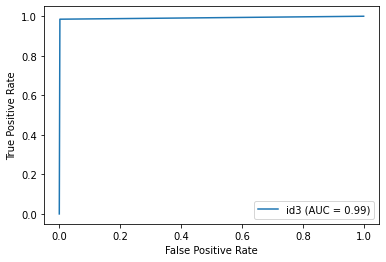

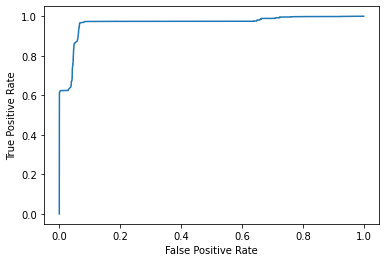

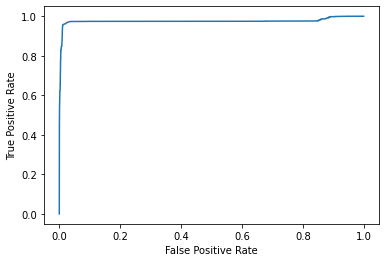

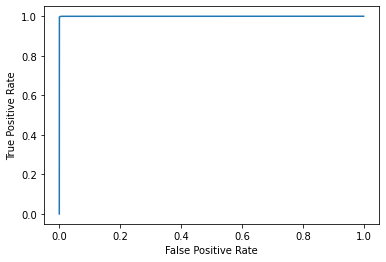

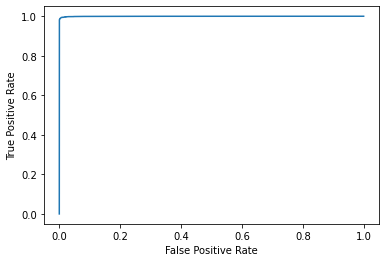

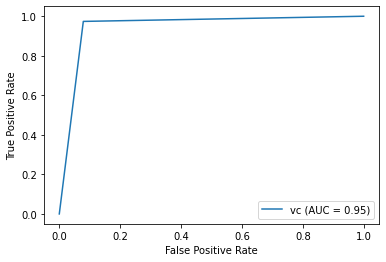

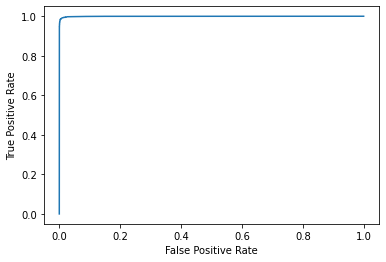

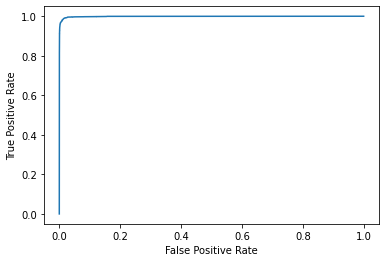

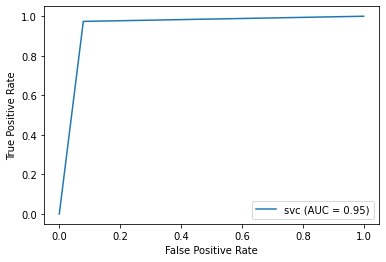

In [ ]:
#calling show_pca_result, which uses PCA
show_pca_result(X,Y,df_c)

## Subtask4 Balancing CICIDS2017, data set using given methods

### using Random under Sampling(RuS), on CICIDS2017:


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=42)
Y = Y.astype('int')
print( "before balancing counts ",Y.value_counts() )
x_rus,y_rus = rus.fit_resample(X, Y)
print( "After balancing counts ",y_rus.value_counts() )

before balancing counts   Label
0         375924
1         131409
dtype: int64
After balancing counts   Label
0         131409
1         131409
dtype: int64


#### After balancing using RUS, and for selectKBest k = 7

Gaussian
[23960  2138 10094 16372]
Logistic Regression
[23930  2168 10134 16332]
RFC
[26014    84   188 26278]
XGB
[25951   147   231 26235]
ADC
[25951   147   458 26008]
MLPC


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[25951   147   458 26008]
ID3
[25960   138   206 26260]
VC
[23953  2145 10128 16338]
SVC
[23912  2186 10202 16264]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.767293 |    0.884495 | 0.618605 |   0.728033 |      0.0592916 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.765961 |    0.882811 | 0.617094 |   0.726416 |      2.20875   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.994825 |    0.996814 | 0.992897 |   0.994851 |     15.1351    |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.992809 |    0.994428 | 0.9912

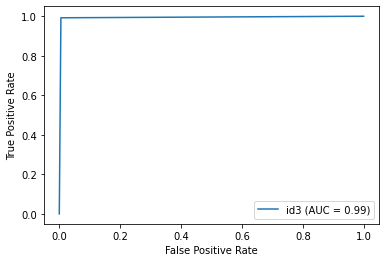

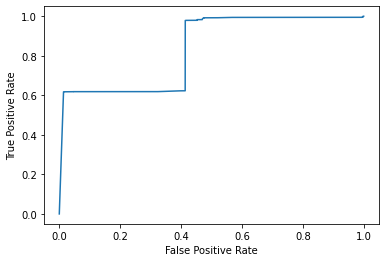

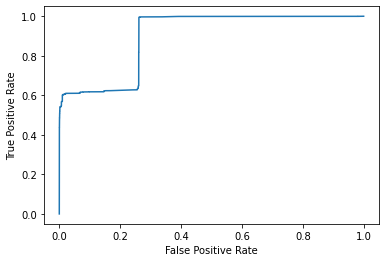

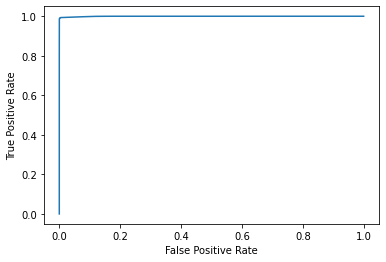

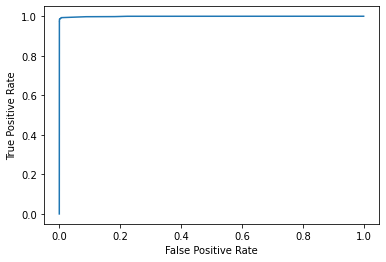

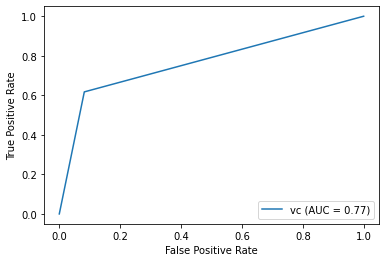

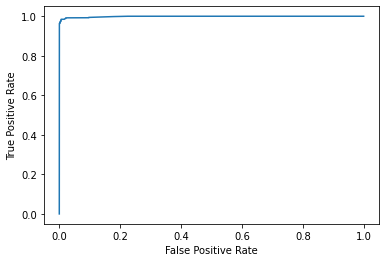

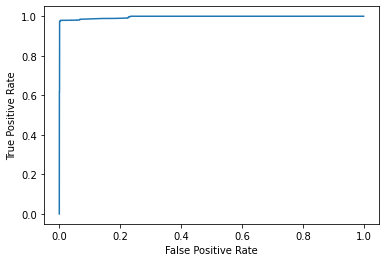

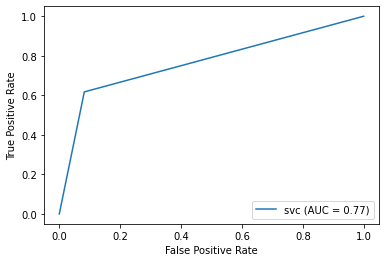

In [ ]:
select_k_result(7, x_rus, y_rus)

#### After balancing using RUS, and for selectKBest k = 8

Gaussian
[24265  2025  9899 16375]
Logistic Regression
[26021   269 10116 16158]
RFC
[26200    90   197 26077]
XGB
[26136   154   243 26031]
ADC
[26149   141   707 25567]
MLPC


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[26149   141   707 25567]
ID3
[26264    26   308 25966]
VC
[26097   193 10116 16158]
SVC
[26110   180 10118 16156]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.773153 |    0.889946 | 0.62324  |   0.733089 |       0.094384 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.802431 |    0.983625 | 0.614981 |   0.756797 |       5.5879   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.99454  |    0.996561 | 0.992502 |   0.994527 |      17.8258   |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.992447 |    0.994119 | 0.9907

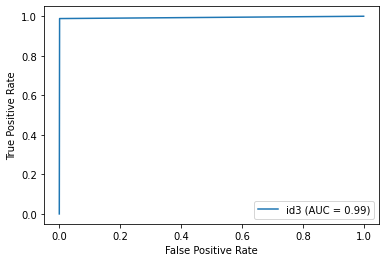

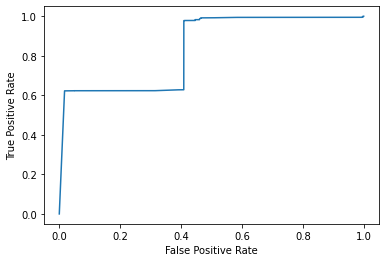

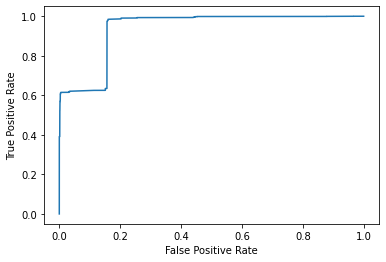

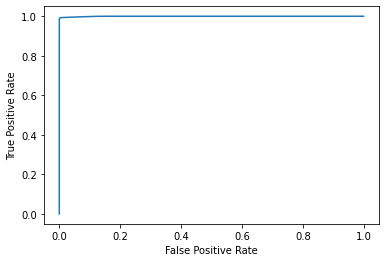

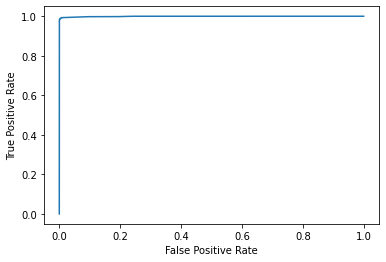

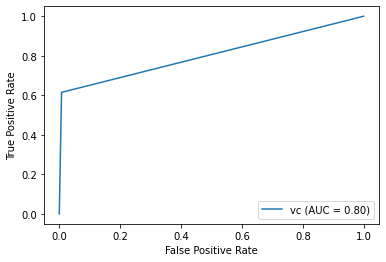

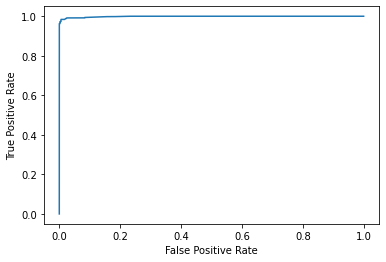

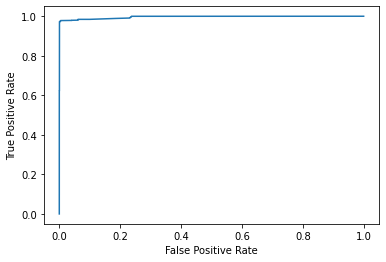

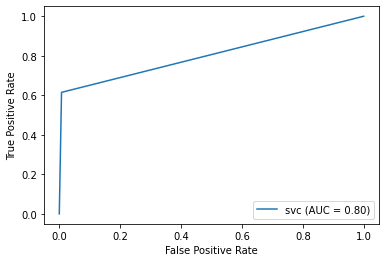

In [ ]:
select_k_result(8, x_rus, y_rus)

#### After balancing using RUS, and for selectKBest k = 9

Gaussian 
[24539  1857  9892 16276]
Logistic Regression
[26048   348 10134 16034]
RFC
[26301    95   191 25977]
XGB
[26249   147   216 25952]
ADC
[26201   195   313 25855]
MLPC
[26201   195   313 25855]
ID3
[26275   121   204 25964]
VC
[26117   279 10133 16035]
SVC
[26095   301 10136 16032]
+---------------------+------------+-------------+----------+------------+----------------+
| Mode                |   Accuracy |   Precision |   Recall |   F1-socre |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.776482 |    0.89759  | 0.621981 |   0.734792 |      0.0941873 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.800586 |    0.978757 | 0.612733 |   0.753655 |      6.44204   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.994559 |    0.996356 | 0.992701 |   

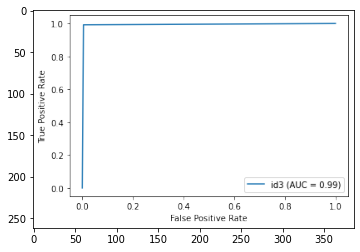

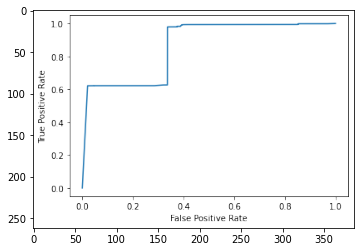

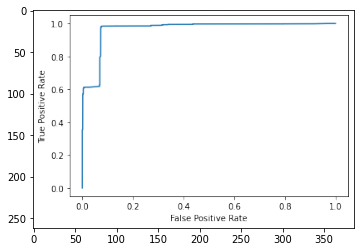

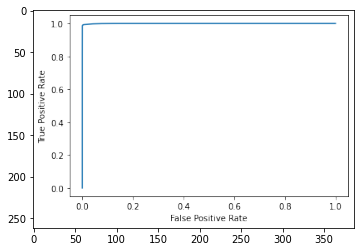

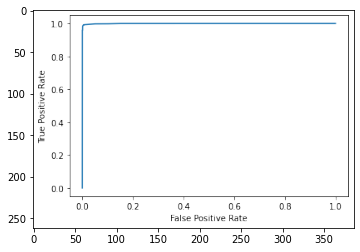

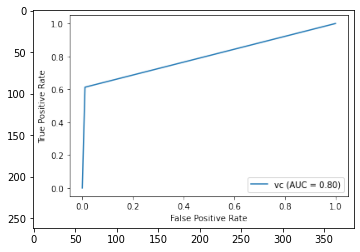

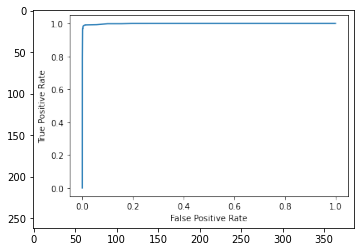

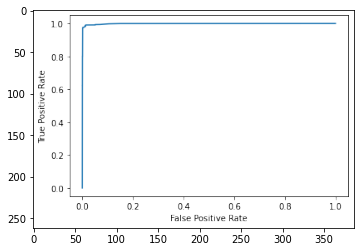

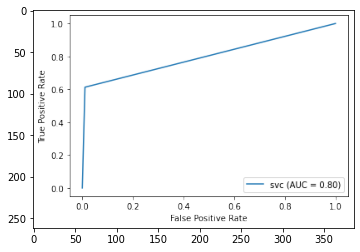

In [ ]:
select_k_result(9, x_rus, y_rus)

#### Bonus part: Using PCA on CICIDS2017: balanced( using random under sampling )  

pca components =  6
Gaussian
[23143  3119   726 25576]
Logistic Regression
[23542  2720   651 25651]
RFC
[26213    49    55 26247]
XGB
[26105   157   127 26175]
ADC
[26049   213   157 26145]
MLPC
[26049   213   157 26145]
ID3
[25919   343   170 26132]
VC
[23541  2721   651 25651]
SVC
[23543  2719   651 25651]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.926851 |    0.891305 | 0.972398 |   0.930087 |      0.0594966 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.935869 |    0.904127 | 0.975249 |   0.938343 |      1.05397   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.998021 |    0.998

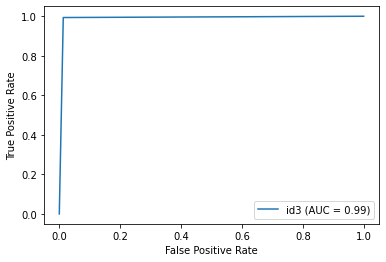

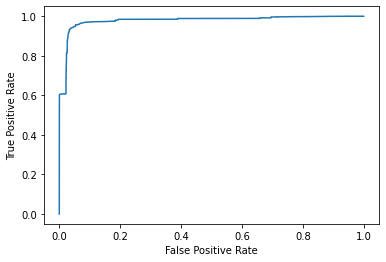

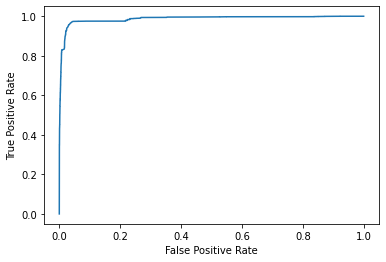

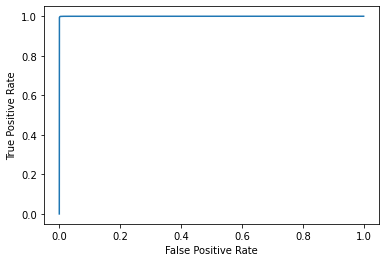

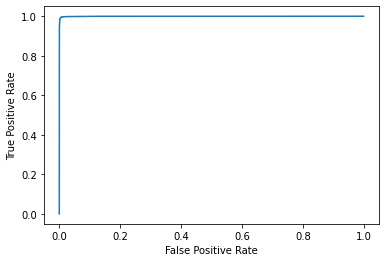

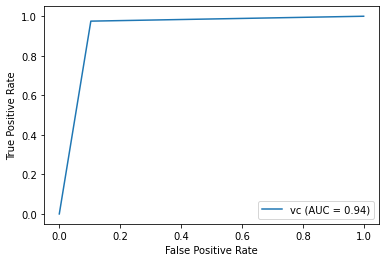

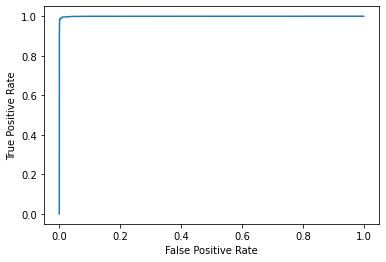

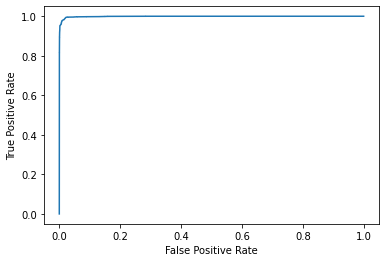

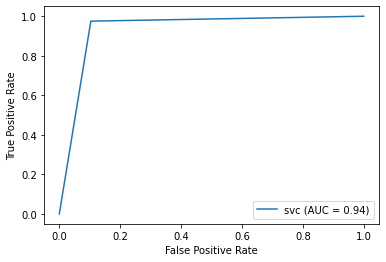

In [ ]:
show_pca_result(x_rus,y_rus,df_c)

### using Random over Sampling(ROS), on CICIDS2017:

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
Y = Y.astype('int')
print( Y.value_counts() )
x_ros,y_ros = ros.fit_resample(X, Y)
print( y_ros.value_counts() )

 Label
0         375924
1         131409
dtype: int64
 Label
0         375924
1         375924
dtype: int64


#### After balancing using ROS, and for selectKBest k = 7

Gaussian
[69339  6019 28554 46458]
Logistic Regression
[68734  6624 29161 45851]
RFC
[75098   260   536 74476]
XGB
[74893   465   659 74353]
ADC
[74974   384  1337 73675]
MLPC
[74974   384  1337 73675]
ID3
[74954   404   594 74418]
VC
[69029  6329 28840 46172]
SVC
[68984  6374 28841 46171]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.77008  |    0.885302 | 0.619341 |   0.728816 |        0.19912 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.76202  |    0.873768 | 0.611249 |   0.719305 |       10.6213  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.994706 |    0.996521 | 0.992854 |   0

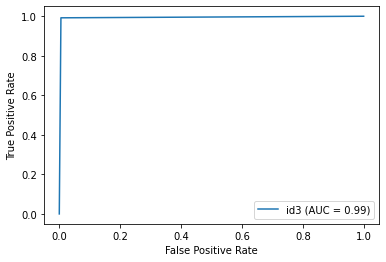

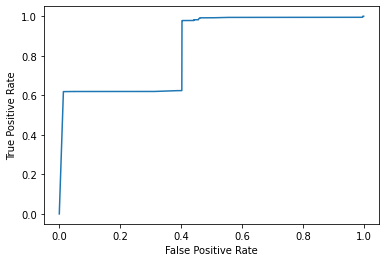

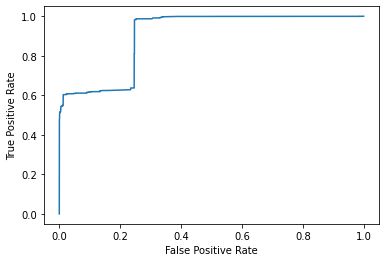

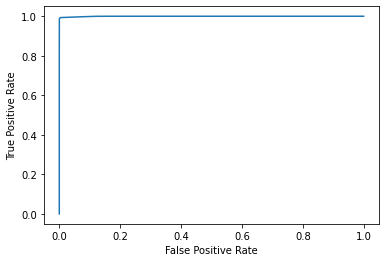

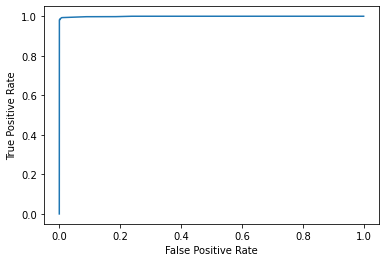

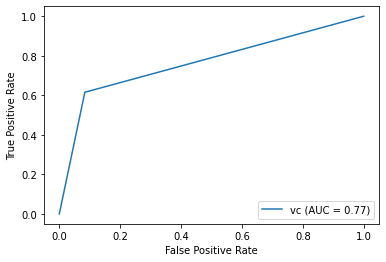

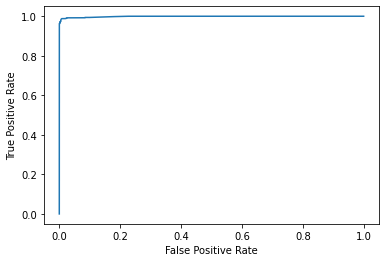

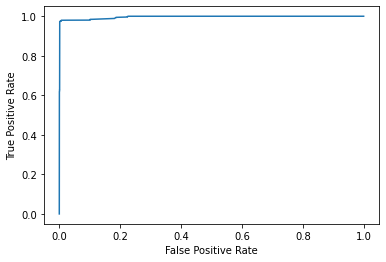

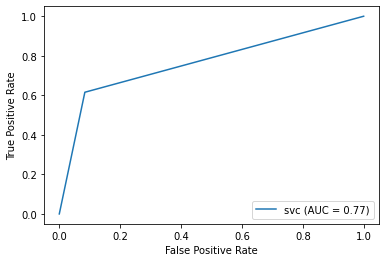

In [ ]:
select_k_result(7, x_ros, y_ros)

#### After balancing using ROS, and for selectKBest k = 8

Gaussian
[69528  5762 28797 46283]
Logistic Regression
[74686   604 29412 45668]
RFC
[75028   262   549 74531]
XGB
[74810   480   708 74372]
ADC
[74862   428  1350 73730]
MLPC
[74862   428  1350 73730]
ID3
[74866   424   586 74494]
VC


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[74710   580 29411 45669]
SVC
[74575   715 29630 45450]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.770174 |    0.889288 | 0.616449 |   0.728149 |        0.18946 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.800386 |    0.986947 | 0.608258 |   0.752653 |       12.3975  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.994607 |    0.996497 | 0.992688 |   0.994589 |       90.0237  |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.992099 |    0.993587 | 0.99057  |   0.992076 |       42.1266  |
+---------------------+-

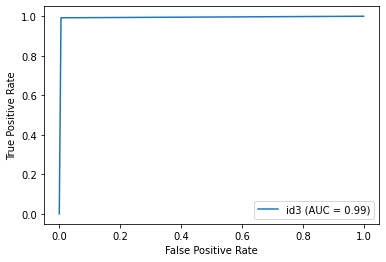

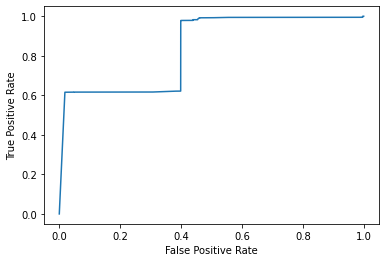

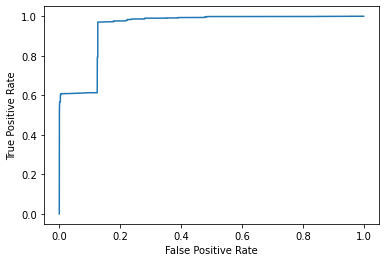

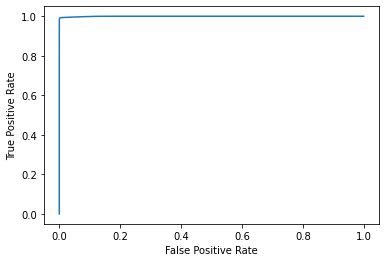

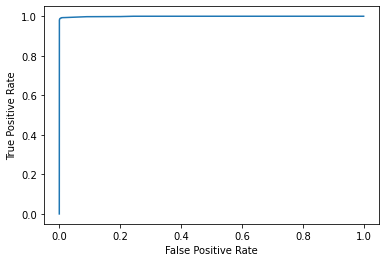

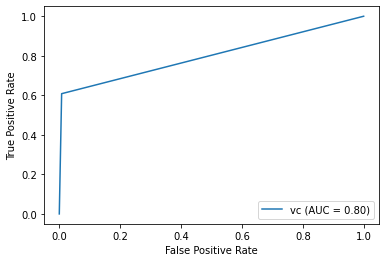

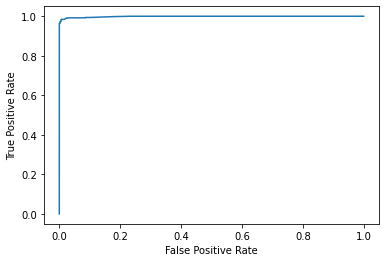

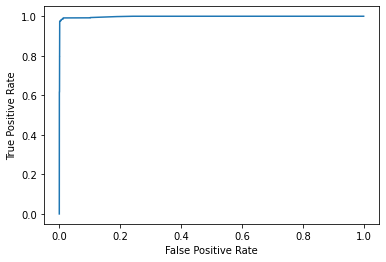

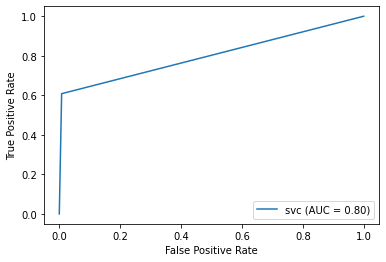

In [ ]:
select_k_result(8, x_ros, y_ros)

#### After balancing using ROS, and for selectKBest k = 9

Gaussian
[69850  5177 28743 46600]
Logistic Regression
[74191   836 29428 45915]
RFC
[74780   247   554 74789]
XGB
[74600   427   689 74654]
ADC
[74467   560   951 74392]
MLPC
[74467   560   951 74392]
ID3
[74686   341   590 74753]
VC


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[74213   814 29421 45922]
SVC
[70522  4505  2040 73303]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.774423 |    0.900014 | 0.618505 |   0.733166 |       0.219091 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.798736 |    0.982118 | 0.609413 |   0.752125 |      14.6283   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.994673 |    0.996708 | 0.992647 |   0.994673 |     123.879    |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.992578 |    0.994313 | 0.990855 |   0.992581 |      41.6429   |
+---------------------+-

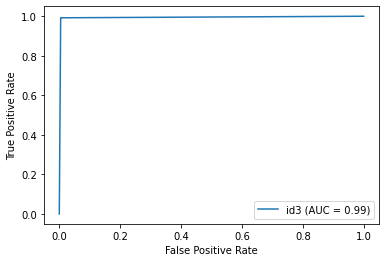

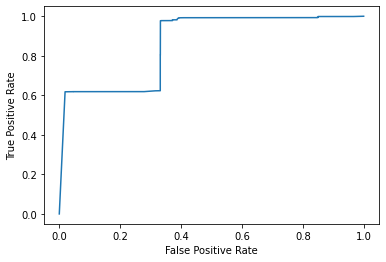

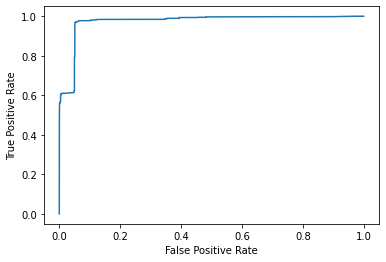

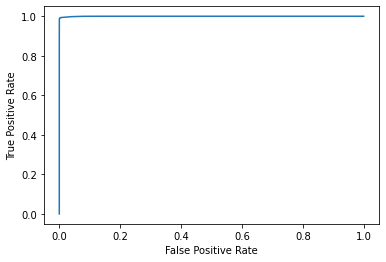

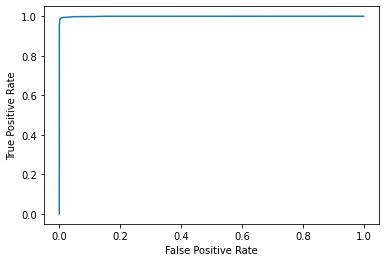

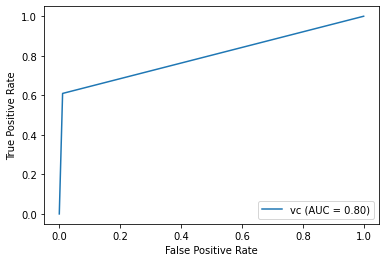

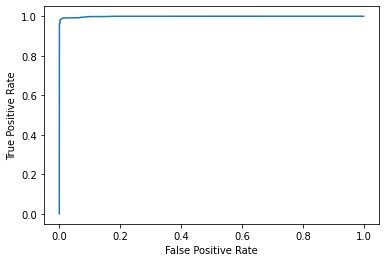

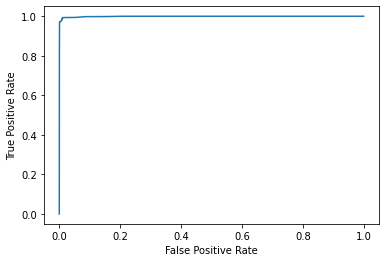

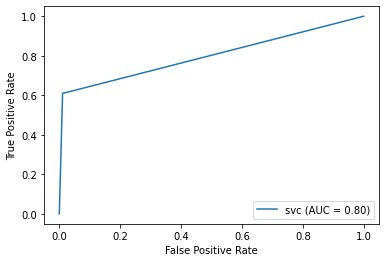

In [ ]:
select_k_result(9, x_ros, y_ros)

#### Bonus part: Using PCA on CICIDS2017 balanced(using random over sampling)  

In [ ]:
print(x_ros.shape, y_ros.shape, y_ros.value_counts())

(751848, 77) (751848, 1)  Label
0         375924
1         375924
dtype: int64


pca components =  6
Gaussian
[66224  9093  2170 72883]
Logistic Regression
[67486  7831  1972 73081]
RFC
[75192   125    25 75028]
XGB
[74819   498   373 74680]
ADC
[74632   685   461 74592]
MLPC
[74632   685   461 74592]
ID3
[74529   788   571 74482]
VC
[67464  7853  1972 73081]
SVC
[67484  7833  1972 73081]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.925098 |    0.889077 | 0.971087 |   0.928274 |        0.1485  |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.934807 |    0.903216 | 0.973725 |   0.937146 |        3.65958 |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.999002 |    0.998

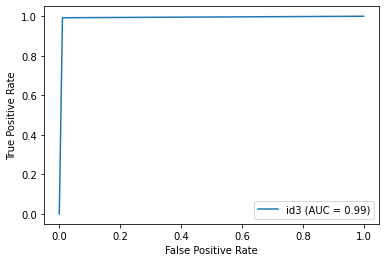

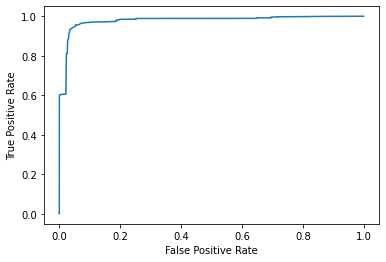

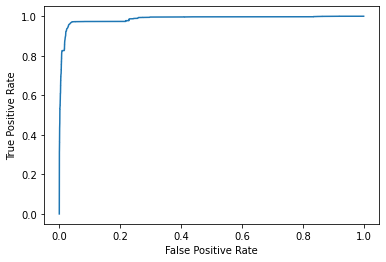

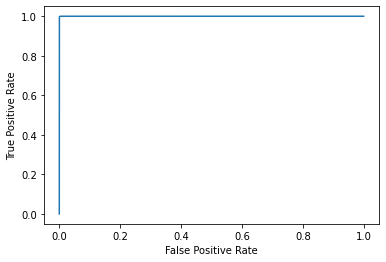

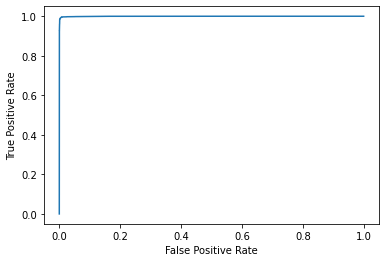

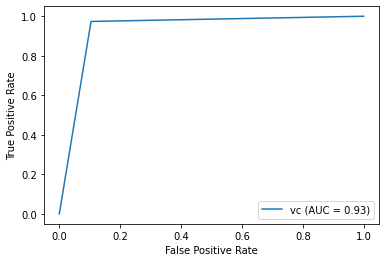

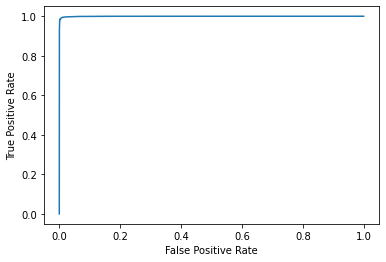

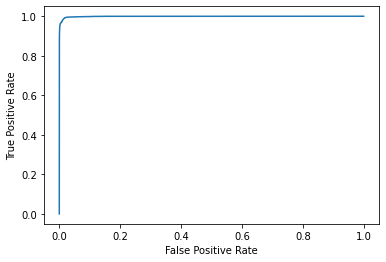

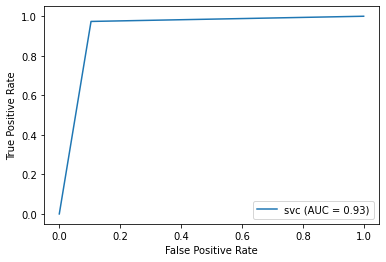

In [ ]:
show_pca_result(x_ros,y_ros,df_c)

### using SMOTE, on CICIDS2017:


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
Y = Y.astype('int')
print( Y.value_counts() )
x_sm, y_sm = sm.fit_resample(X, Y)
print( y_sm.value_counts() )

 Label
0         375924
1         131409
dtype: int64
 Label
0         375924
1         375924
dtype: int64


#### After balancing using SMOTE, and for selectKBest k = 7

Gaussian
[69296  6102 28609 46363]
Logistic Regression
[68788  6610 29193 45779]
RFC
[75120   278   528 74444]
XGB
[74895   503   657 74315]
ADC
[75016   382  2018 72954]
MLPC
[75016   382  2018 72954]
ID3
[74923   475   626 74346]
VC
[69082  6316 29179 45793]
SVC
[69061  6337 29201 45771]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.769163 |    0.883694 | 0.618404 |   0.727622 |       0.245661 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.761901 |    0.873828 | 0.610615 |   0.718886 |       8.9021   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.99464  |    0.99628  | 0.992957 |   0

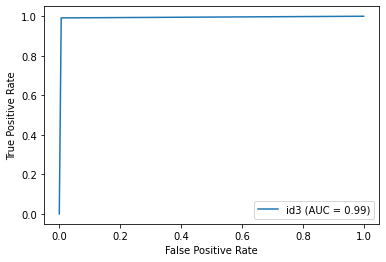

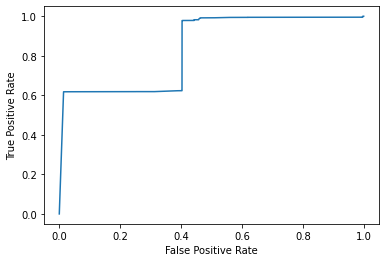

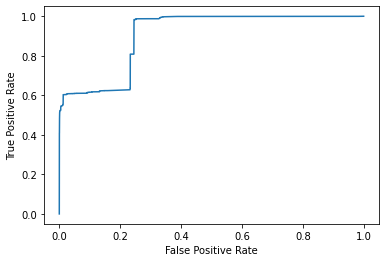

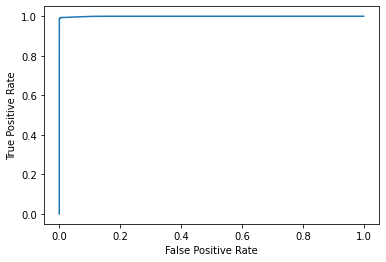

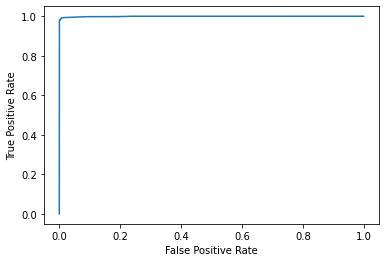

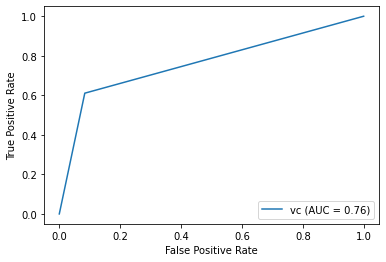

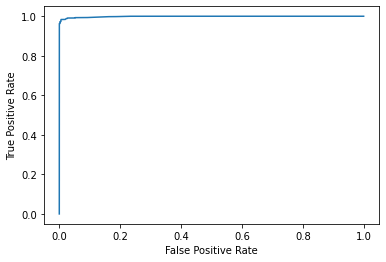

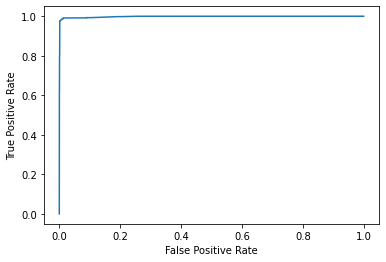

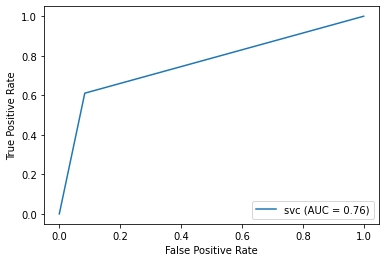

In [ ]:
select_k_result(7, x_sm, y_sm)

#### After balancing using SMOTE, and for selectKBest k = 8

Gaussian
[69292  5760 28447 46871]
Logistic Regression
[74402   650 29127 46191]
RFC
[74791   261   533 74785]
XGB
[74569   483   685 74633]
ADC
[74610   442  2013 73305]
MLPC


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[74610   442  2013 73305]
ID3
[74629   423   593 74725]
VC
[74498   554 29125 46193]
SVC
[74351   701 29132 46186]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.772514 |    0.890559 | 0.622308 |   0.732651 |       0.176845 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.801975 |    0.986123 | 0.61328  |   0.756244 |       9.60423  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.99472  |    0.996522 | 0.992923 |   0.994719 |     108.972    |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.992232 |    0.99357  | 0.9909

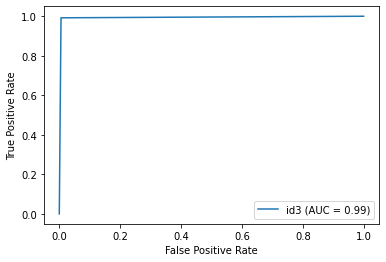

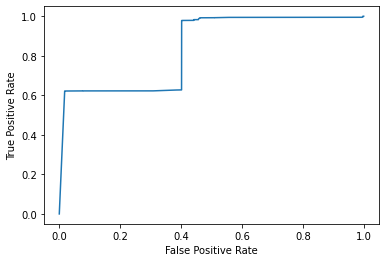

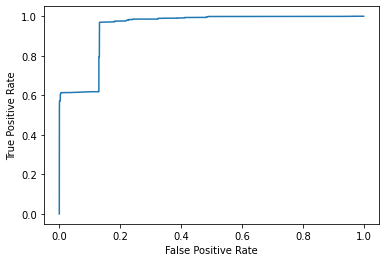

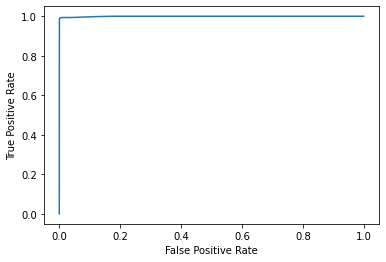

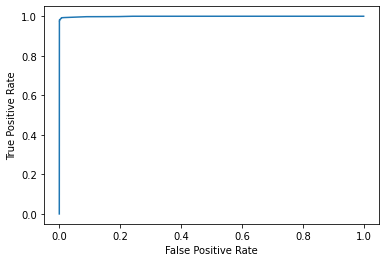

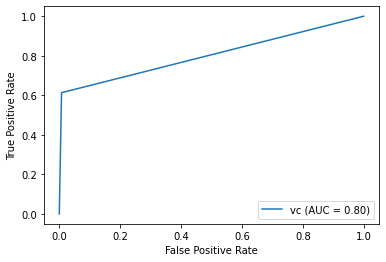

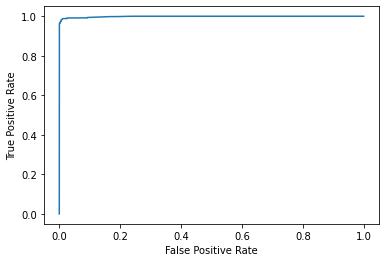

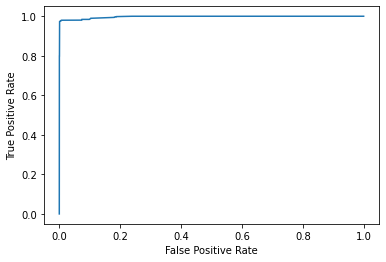

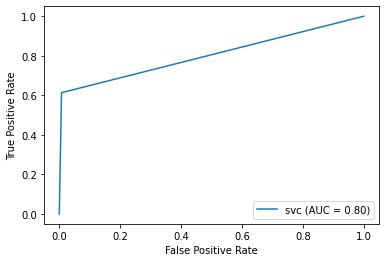

In [ ]:
select_k_result(8, x_sm, y_sm)

#### After balancing using SMOTE, and for selectKBest k = 9

Gaussian
[3644  267  605 1484]
Logistic Regression
[3903    8  608 1481]
RFC
[3911    0    2 2087]
XGB
[3911    0    2 2087]
ADC
[3905    6    2 2087]
MLPC


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[3905    6    2 2087]
ID3
[3911    0    2 2087]
VC
[3903    8  608 1481]
SVC
[3910    1  617 1472]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.854667 |    0.847516 | 0.710388 |   0.772917 |      0.0290723 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.897333 |    0.994627 | 0.708952 |   0.827837 |      0.37318   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.999667 |    1        | 0.999043 |   0.999521 |      1.66917   |
+---------------------+------------+-------------+----------+------------+----------------+
| XGB                 |   0.999667 |    1        | 0.999043 |   0.999521 

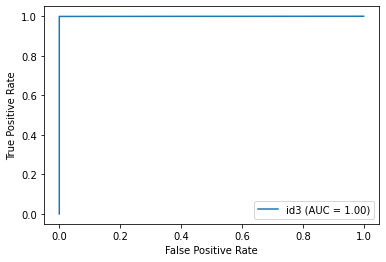

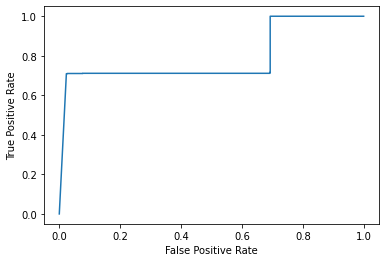

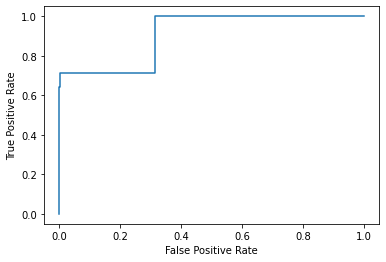

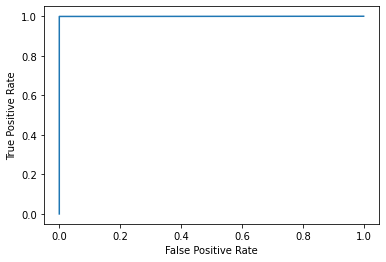

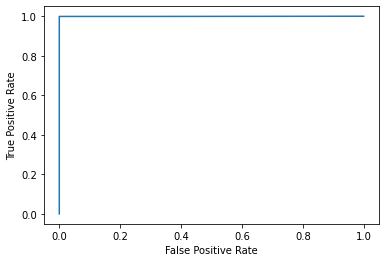

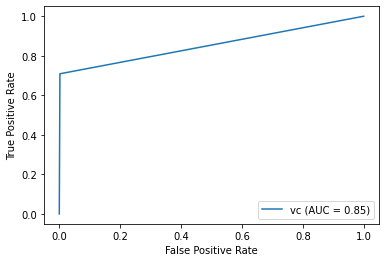

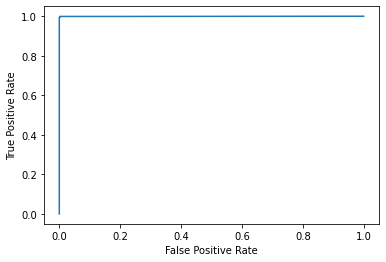

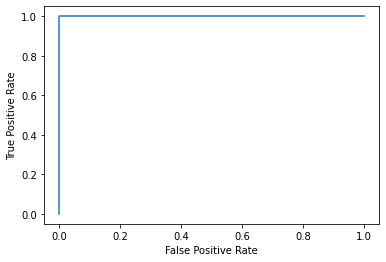

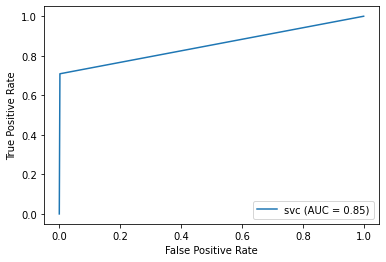

In [ ]:
select_k_result(9,a,b)

#### Bonus part: Using PCA on CICIDS2017 balanced(using SMOTE)  

pca components =  6
Gaussian
[65994  9265  1949 73162]
Logistic Regression
[67356  7903  1800 73311]
RFC
[75128   131   121 74990]
XGB
[74759   500   409 74702]
ADC
[74611   648   448 74663]
MLPC
[74611   648   448 74663]
ID3
[74484   775   539 74572]
VC
[67342  7917  1800 73311]
SVC
[67332  7927  1800 73311]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.925424 |    0.887598 | 0.974052 |   0.928817 |        0.16557 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.935473 |    0.902689 | 0.976035 |   0.937931 |        3.64588 |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.998324 |    0.998

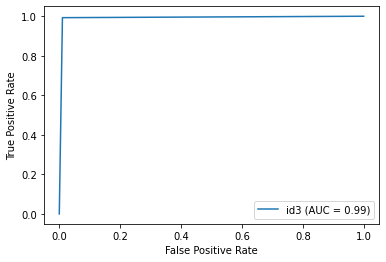

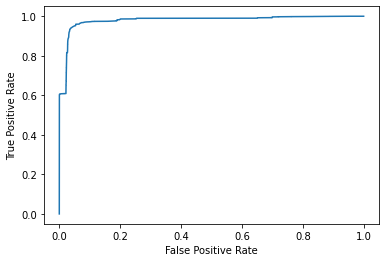

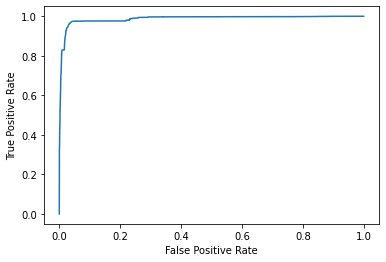

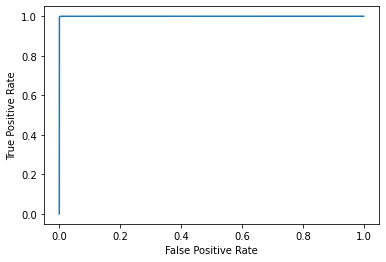

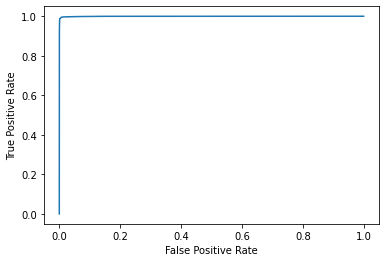

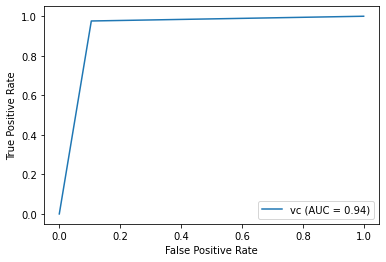

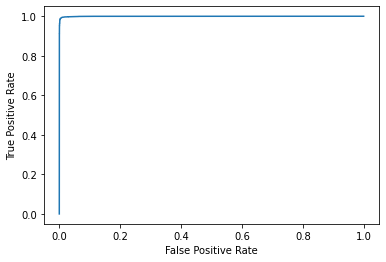

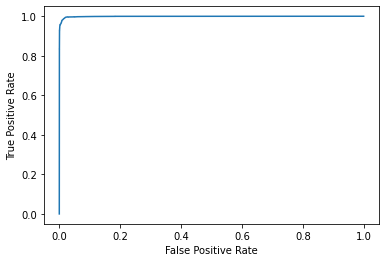

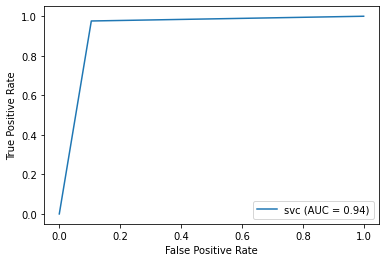

In [ ]:
show_pca_result(x_sm,y_sm,df_c)

#------------------------------------------------END for CICIDS2017 dataset------------------------------------------------

# unsw-nb15

## Subtask1 pre-processing

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# reading fetures file
df_feature_name = pd.read_csv("gdrive/MyDrive/sem2/NS dataset/NUSW-NB15_features.csv",encoding='cp1252')
col_names = df_feature_name['Name']

In [ ]:
print(col_names)

0                srcip
1                sport
2                dstip
3               dsport
4                proto
5                state
6                  dur
7               sbytes
8               dbytes
9                 sttl
10                dttl
11               sloss
12               dloss
13             service
14               Sload
15               Dload
16               Spkts
17               Dpkts
18                swin
19                dwin
20               stcpb
21               dtcpb
22             smeansz
23             dmeansz
24         trans_depth
25         res_bdy_len
26                Sjit
27                Djit
28               Stime
29               Ltime
30             Sintpkt
31             Dintpkt
32              tcprtt
33              synack
34              ackdat
35     is_sm_ips_ports
36        ct_state_ttl
37    ct_flw_http_mthd
38        is_ftp_login
39          ct_ftp_cmd
40          ct_srv_src
41          ct_srv_dst
42          ct_dst_ltm
43         

In [ ]:
#reading data files
df4 = pd.read_csv("gdrive/MyDrive/sem2/NS dataset/UNSW-NB15_3.csv",header=None, names = col_names)
df5 = pd.read_csv("gdrive/MyDrive/sem2/NS dataset/UNSW-NB15_4.csv",header=None, names = col_names)
print("Do these 2 data frame have same columns? ",list(df4.columns)==list(df5.columns))

Do these 2 data frame have same columns?  True


In [ ]:
#concatenate both data frames into single data frame
df_d = pd.concat([df4,df5])
print(df_d.shape)
df_d.head()

(1140045, 49)


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.1,18247,149.171.126.4,7662,tcp,FIN,0.119596,4550,68342,31,...,,6,2,2,5,1,1,2,NaN,0
1,59.166.0.3,54771,149.171.126.2,27709,tcp,FIN,0.650574,8928,320,31,...,,3,5,2,4,1,1,4,NaN,0
2,59.166.0.8,13289,149.171.126.9,5190,tcp,FIN,0.007980,2158,2464,31,...,,3,5,1,1,1,1,3,NaN,0
3,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,...,,19,19,19,19,19,19,19,NaN,0
4,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,...,,19,19,19,19,19,19,19,NaN,0


In [ ]:
#dropping unnecessary columns
cols_to_drop = ['srcip','sport','dstip','dsport']
df_d.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
print(df_d.dtypes.to_dict())

{'proto': dtype('O'), 'state': dtype('O'), 'dur': dtype('float64'), 'sbytes': dtype('int64'), 'dbytes': dtype('int64'), 'sttl': dtype('int64'), 'dttl': dtype('int64'), 'sloss': dtype('int64'), 'dloss': dtype('int64'), 'service': dtype('O'), 'Sload': dtype('float64'), 'Dload': dtype('float64'), 'Spkts': dtype('int64'), 'Dpkts': dtype('int64'), 'swin': dtype('int64'), 'dwin': dtype('int64'), 'stcpb': dtype('int64'), 'dtcpb': dtype('int64'), 'smeansz': dtype('int64'), 'dmeansz': dtype('int64'), 'trans_depth': dtype('int64'), 'res_bdy_len': dtype('int64'), 'Sjit': dtype('float64'), 'Djit': dtype('float64'), 'Stime': dtype('int64'), 'Ltime': dtype('int64'), 'Sintpkt': dtype('float64'), 'Dintpkt': dtype('float64'), 'tcprtt': dtype('float64'), 'synack': dtype('float64'), 'ackdat': dtype('float64'), 'is_sm_ips_ports': dtype('int64'), 'ct_state_ttl': dtype('int64'), 'ct_flw_http_mthd': dtype('float64'), 'is_ftp_login': dtype('float64'), 'ct_ftp_cmd': dtype('O'), 'ct_srv_src': dtype('int64'), 'c

In [ ]:
d = df_d['attack_cat'].value_counts().to_dict()
d

{' Fuzzers ': 14527,
 ' Reconnaissance ': 9112,
 ' Shellcode ': 964,
 'Analysis': 1543,
 'Backdoor': 1425,
 'DoS': 10549,
 'Exploits': 28013,
 'Generic': 180076,
 'Worms': 110}

In [ ]:
d = df_d['attack_cat'].value_counts().to_dict()
print(d.get(' ',0))
print( df_d.isnull().sum()['attack_cat'] )
print(df_d['attack_cat'].isna().sum())

0
893726
893726


In [ ]:
# dropping columsn havign more than 25% empty values
print("before shape", df_d.shape)
for cols in df_d.columns:
    d = df_d[cols].value_counts().to_dict()
    if( d.get(' ',0)/df_d.shape[0] > 0.25 or df_d[cols].isna().sum() > 0.25 ):
        df_d.drop(cols, axis=1, inplace = True)
        print("Dropped column = ",cols)
print("After shape", df_d.shape)

before shape (1140045, 45)
Dropped column =  ct_flw_http_mthd
Dropped column =  is_ftp_login
Dropped column =  ct_ftp_cmd
Dropped column =  attack_cat
After shape (1140045, 41)


In [ ]:
p = df_d.dropna(axis=1,thresh=int(((100-25)/100)*df_d.shape[0] + 1))
p.shape

(1140045, 41)

##### encoding 'proto' column

In [ ]:
print( df_d['proto'].unique() )

['tcp' 'udp' 'icmp' 'arp' 'ospf' 'udt' 'sctp' 'igmp' 'gre' 'sep' 'swipe'
 'mobile' 'sun-nd' 'pim' 'rtp' 'ip' 'ggp' 'ipnip' 'st2' 'cbt' 'argus'
 'bbn-rcc' 'chaos' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet' 'mux' 'dcn'
 'hmp' 'prm' 'trunk-1' 'trunk-2' 'xns-idp' 'irtp' 'leaf-1' 'leaf-2' 'rdp'
 'iso-tp4' 'netblt' 'merit-inp' 'mfe-nsp' '3pc' 'idpr' 'xtp' 'ddp'
 'idpr-cmtp' 'tp++' 'il' 'ipv6' 'ipv6-route' 'sdrp' 'ipv6-frag' 'idrp'
 'rsvp' 'bna' 'mhrp' 'i-nlsp' 'narp' 'tlsp' 'skip' 'ipv6-no' 'ipv6-opts'
 'any' 'cftp' 'sat-expak' 'kryptolan' 'ippc' 'rvd' 'sat-mon' 'cpnx' 'ipcv'
 'visa' 'cphb' 'wsn' 'br-sat-mon' 'pvp' 'wb-mon' 'iso-ip' 'wb-expak'
 'secure-vmtp' 'vmtp' 'ttp' 'vines' 'nsfnet-igp' 'dgp' 'eigrp' 'tcf'
 'larp' 'sprite-rpc' 'ax.25' 'ipip' 'mtp' 'aes-sp3-d' 'etherip' 'micp'
 'encap' 'pri-enc' 'gmtp' 'ifmp' 'pnni' 'aris' 'scps' 'a/n' 'qnx' 'ipcomp'
 'snp' 'compaq-peer' 'ipx-n-ip' 'vrrp' 'pgm' 'l2tp' 'zero' 'ddx' 'iatp'
 'srp' 'stp' 'uti' 'smp' 'sm' 'ptp' 'fire' 'isis' 'crtp' 'crudp'
 'scco

In [ ]:
#checking for NaN/Null values
idx = df_d["proto"].isna()
print(df_d[idx]["proto"])
#as you can see there is no null/NaN values in this column

Series([], Name: proto, dtype: object)


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_d['proto'] = LabelEncoder().fit_transform(df_d['proto'])

In [ ]:
print(df_d['proto'].unique())

[113 119  37   6  78 120  97  42  32 100 111  71 110  80  91  45  30  50
 108  11   4   8  13  23  25  43  77  86 130  73  19  33  84 116 117 131
  58  65  66  89  61  75  67  68   0  38 132  20  39 115  44  52  56  98
  53  40  90   9  69  34  74 114 101  54  55   3  12  93  62  51  92  94
  16  47 124  15 129  10  87 128  60 127  99 125 118 123  76  22  24 112
  64 105   7  48  72   2  27  70  26  83  31  41  82   5  96   1  88  46
 104  14  57 126  79  63 133  21  35 107 109 122 103 102  85  29  59  17
  18  95  49  81 106  28 121  36]


##### encoding ''state'' column

In [ ]:
col_name = 'state'
print( df_d[col_name].unique() )

['FIN' 'INT' 'CON' 'ECO' 'REQ' 'PAR' 'ACC' 'RST' 'TST' 'ECR' 'TXD' 'no'
 'URN' 'MAS']


In [ ]:
#checking for NaN/Null values
idx = df_d[col_name].isna()
print(df_d[idx][col_name])
#as you can see there is no null/NaN values in this column

Series([], Name: state, dtype: object)


In [ ]:
df_d[col_name] = LabelEncoder().fit_transform(df_d[col_name])

In [ ]:
df_d[col_name].unique()

array([ 4,  5,  1,  2,  8,  7,  0,  9, 10,  3, 11, 13, 12,  6])

##### encoding column 'service'

In [ ]:
col_name = 'service'
print( df_d[col_name].unique() )

['-' 'ftp-data' 'dns' 'smtp' 'http' 'ftp' 'ssh' 'pop3' 'dhcp' 'snmp' 'ssl'
 'irc' 'radius']


In [ ]:
x = df_d[col_name].mode()
print("x=",x[0])
print(df_d.loc[df_d[col_name] == "-", col_name])

x= dns
0         -
2         -
6         -
7         -
13        -
         ..
440025    -
440026    -
440034    -
440035    -
440038    -
Name: service, Length: 447419, dtype: object


In [ ]:
df_d.loc[df_d[col_name] == "-", col_name] = df_d[col_name].mode()[0]
print( df_d[col_name].unique() )

['dns' 'ftp-data' 'smtp' 'http' 'ftp' 'ssh' 'pop3' 'dhcp' 'snmp' 'ssl'
 'irc' 'radius']


In [ ]:
df_d[col_name] = LabelEncoder().fit_transform(df_d[col_name])
df_d[col_name].unique()

array([ 1,  3,  8,  4,  2, 10,  6,  0,  9, 11,  5,  7])

In [ ]:
print(df_d.dtypes.to_dict())

{'proto': dtype('int64'), 'state': dtype('int64'), 'dur': dtype('float64'), 'sbytes': dtype('int64'), 'dbytes': dtype('int64'), 'sttl': dtype('int64'), 'dttl': dtype('int64'), 'sloss': dtype('int64'), 'dloss': dtype('int64'), 'service': dtype('int64'), 'Sload': dtype('float64'), 'Dload': dtype('float64'), 'Spkts': dtype('int64'), 'Dpkts': dtype('int64'), 'swin': dtype('int64'), 'dwin': dtype('int64'), 'stcpb': dtype('int64'), 'dtcpb': dtype('int64'), 'smeansz': dtype('int64'), 'dmeansz': dtype('int64'), 'trans_depth': dtype('int64'), 'res_bdy_len': dtype('int64'), 'Sjit': dtype('float64'), 'Djit': dtype('float64'), 'Stime': dtype('int64'), 'Ltime': dtype('int64'), 'Sintpkt': dtype('float64'), 'Dintpkt': dtype('float64'), 'tcprtt': dtype('float64'), 'synack': dtype('float64'), 'ackdat': dtype('float64'), 'is_sm_ips_ports': dtype('int64'), 'ct_state_ttl': dtype('int64'), 'ct_srv_src': dtype('int64'), 'ct_srv_dst': dtype('int64'), 'ct_dst_ltm': dtype('int64'), 'ct_src_ ltm': dtype('int64'

In [ ]:
print(set(df_d.dtypes.to_dict().values()))

{dtype('int64'), dtype('float64')}


In [ ]:
df_d.replace([np.inf, -np.inf], np.nan, inplace=True)

##### replacing all na/nulls with mean values

In [ ]:
# printing column name having atleast one null
for cols in df_d.columns:
    if( cols == "Label" ):
        continue
    if( df_d[cols].isnull().values.any() == True):
        print( cols )
#filling null values with mean
for cols in df_d.columns:
    if( cols == "Label" ):
        continue
    df_d[cols] = df_d[cols].fillna(df_d[cols].mean())
#prints the columsn having atlest one NaN
for cols in df_d.columns:
    if( cols == " Label" ):
        continue
    if( df_d[cols].isnull().values.any() == True):
        print( cols )

##### removing duplicates

In [ ]:
print("before",df_d.shape)
cols = list(df_d.columns)
cols.remove('Label')
df_d.drop_duplicates(subset = cols, inplace=True,  keep='first')
print("After",df_d.shape)

before (1140045, 41)
After (774079, 41)


In [ ]:
df_d['Label'].value_counts()

0    716499
1     57580
Name: Label, dtype: int64

In [ ]:
X = df_d.iloc[:,:-1]
Y = df_d.iloc[:,-1:]

## Subtask2 and Subtask3

#### For unbalaced unsw-nb15, for selectbest k = 7, applying on all models

Gaussian
[135522   7686    121  11487]
Logistic Regression
[139890   3318   4690   6918]
RFC
[141331   1877   1394  10214]
XGB
[141084   2124   1038  10570]
ADC
[141138   2070   1263  10345]
MLPC
[141138   2070   1263  10345]
ID3
[141828   1380   2187   9421]
VC
[139186   4022   2791   8817]
SVC
[139190   4018   2791   8817]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.949572 |    0.599124 | 0.989576 |   0.74637  |       0.186449 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.948274 |    0.67585  | 0.595968 |   0.6334   |       8.19415  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

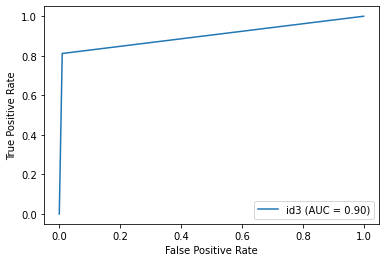

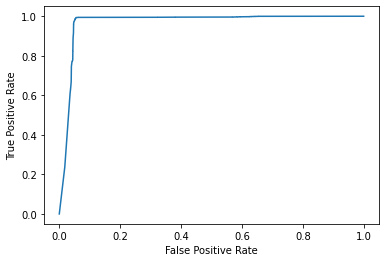

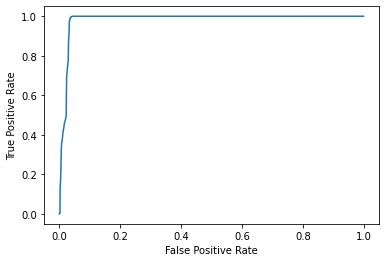

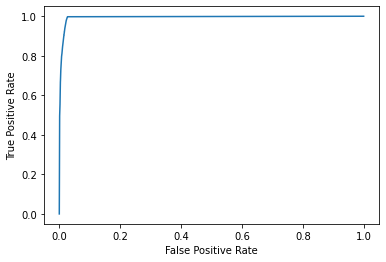

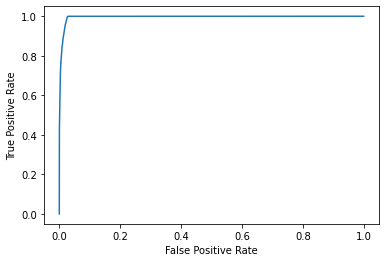

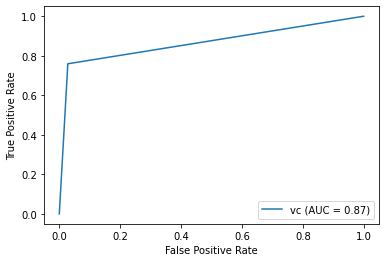

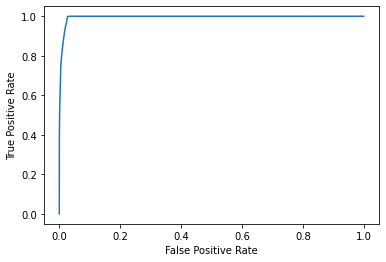

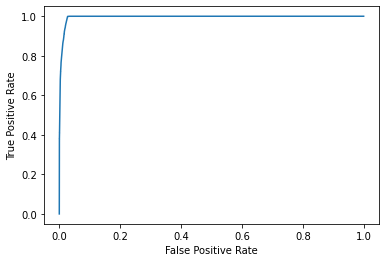

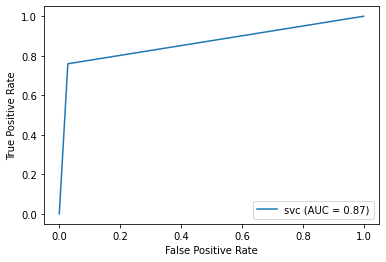

In [ ]:
select_k_result(7, X, Y)

#### For unbalaced unsw-nb15, for selectbest k = 8, applying on all models

Gaussian
[135475   7838    148  11355]
Logistic Regression
[139980   3333   3971   7532]
RFC
[141595   1718   1226  10277]
XGB
[141628   1685   1143  10360]
ADC
[141518   1795   1165  10338]
MLPC
[141518   1795   1165  10338]
ID3
[141919   1394   2088   9415]
VC
[139270   4043   2153   9350]
SVC
[139272   4041   2187   9316]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.948416 |    0.591622 | 0.987134 |   0.739836 |       0.181937 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.952821 |    0.693235 | 0.654786 |   0.673462 |       4.71419  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

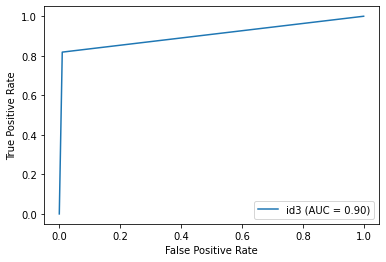

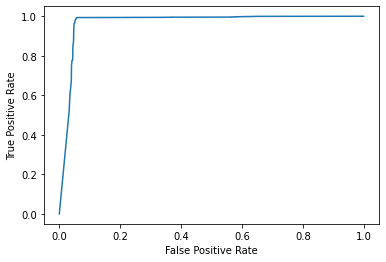

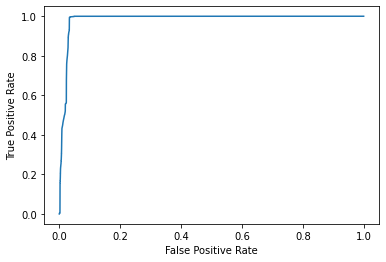

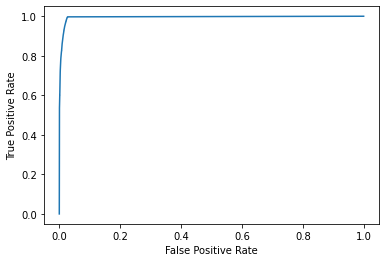

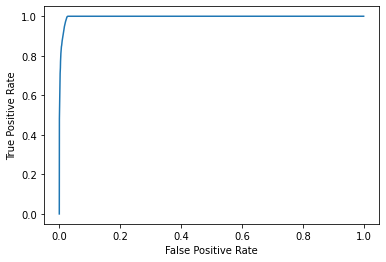

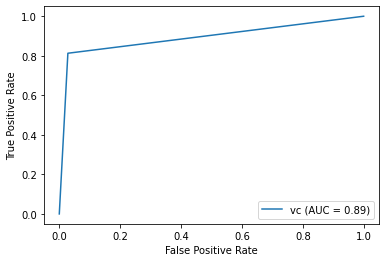

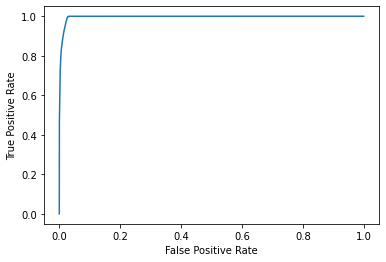

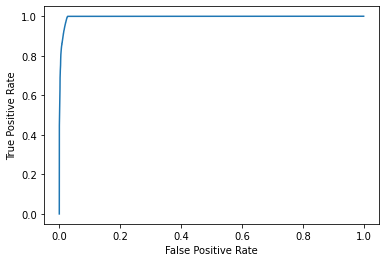

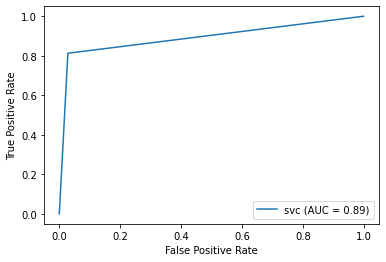

In [ ]:
select_k_result(8, X, Y)

#### For unbalaced unsw-nb15, for selectbest k = 9, applying on all models

---



Gaussian
[135780   7568    145  11323]
Logistic Regression
[140150   3198   3784   7684]
RFC
[141837   1511   1152  10316]
XGB
[141814   1534   1131  10337]
ADC
[141687   1661   1172  10296]
MLPC
[141687   1661   1172  10296]
ID3
[142249   1099   1940   9528]
VC
[139563   3785   2110   9358]
SVC
[139565   3783   2143   9325]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.95018  |    0.599386 | 0.987356 |   0.74594  |       0.185011 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.954901 |    0.70612  | 0.670038 |   0.687606 |       5.6595   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

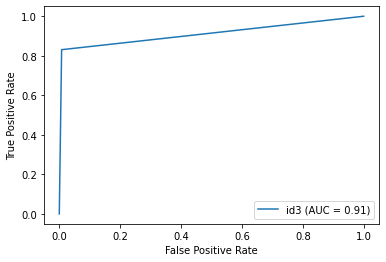

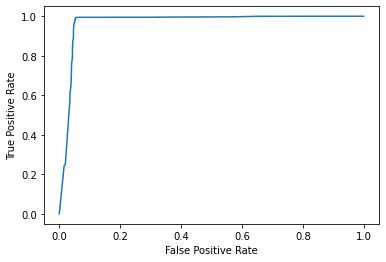

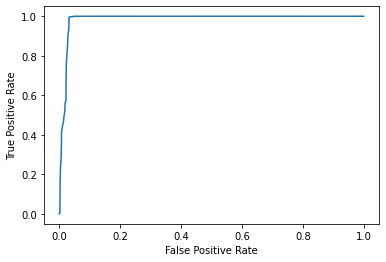

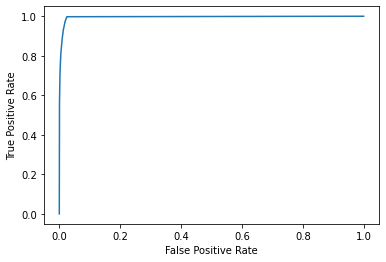

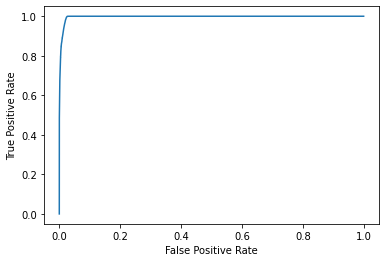

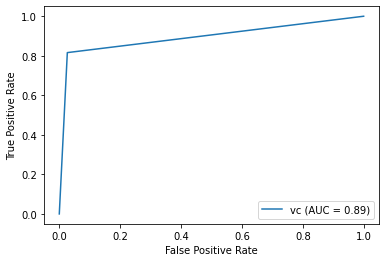

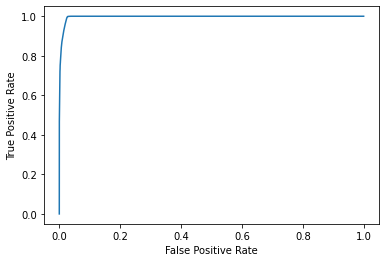

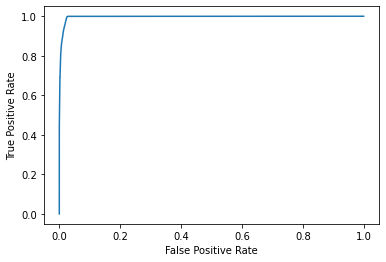

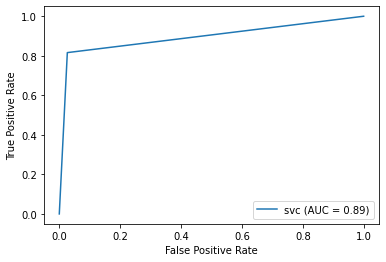

In [ ]:
select_k_result(9, X, Y)

#### Bonus part: using PCA, For unbalaced unsw-nb15, applying all models

In [ ]:
print(X.shape, Y.shape)

(774079, 40) (774079, 1)


pca components =  7
Gaussian
[137067   6328     51  11370]
Logistic Regression
[139750   3645   2573   8848]
RFC
[142068   1327   1099  10322]
XGB
[139714   3681    218  11203]
ADC
[140301   3094    741  10680]
MLPC
[140301   3094    741  10680]
ID3
[138804   4591    107  11314]
VC
[139662   3733   2548   8873]
SVC
[139662   3733   2549   8872]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.958796 |    0.642445 | 0.995535 |   0.780933 |       0.211636 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.959836 |    0.708237 | 0.774713 |   0.739985 |       3.42484  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC    

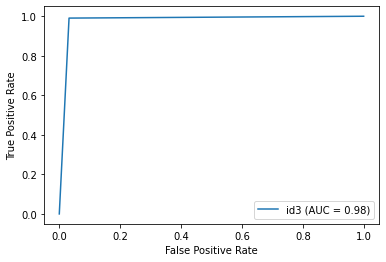

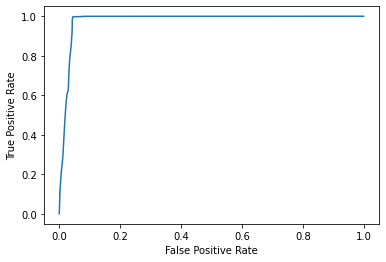

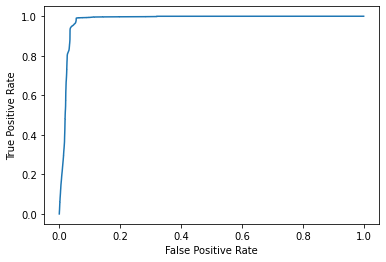

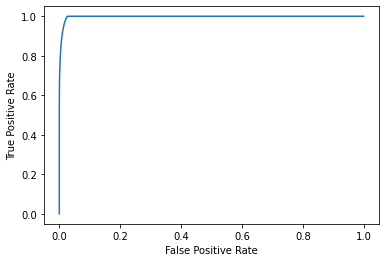

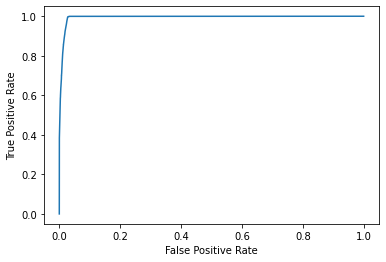

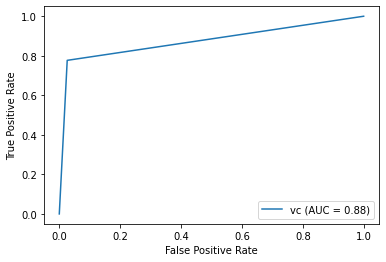

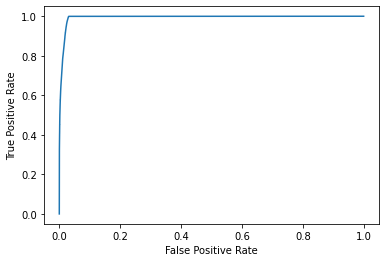

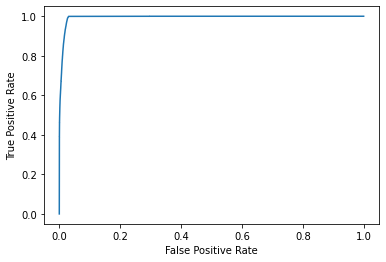

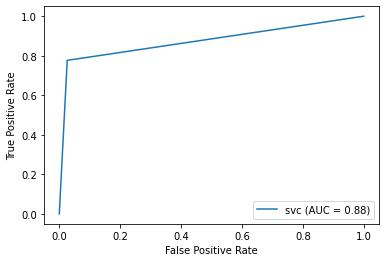

In [ ]:
show_pca_result(X,Y,df_c)

## Subtask4 Balancing unsw-nb15, data set using given methods

### using Random under Sampling(RuS), on unsw-nb15:


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
Y.shape

(774079, 1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
Y = Y.astype('int')
print( "before balancing counts ",Y.value_counts() )
x_rus,y_rus = rus.fit_resample(X, Y)
print( "After balancing counts ",y_rus.value_counts() )

before balancing counts  Label
0        716499
1         57580
dtype: int64
After balancing counts  Label
0        57580
1        57580
dtype: int64


#### After balancing using RUS, and for selectKBest k = 7

Gaussian
[10957   580   102 11393]
Logistic Regression
[11189   348    47 11448]
RFC
[11269   268   109 11386]
XGB
[11244   293     8 11487]
ADC
[11239   298    32 11463]
MLPC
[11239   298    32 11463]
ID3
[11239   298    17 11478]
VC
[11176   361    43 11452]
SVC
[11176   361    48 11447]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.970389 |    0.951558 | 0.991127 |   0.970939 |      0.0444741 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.98285  |    0.970498 | 0.995911 |   0.983041 |      0.947609  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.983631 |    0.977004 | 0.990518 |   0

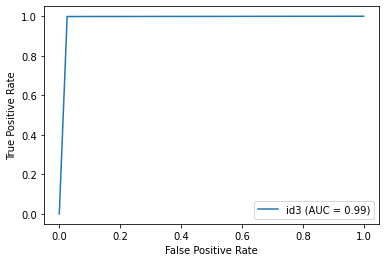

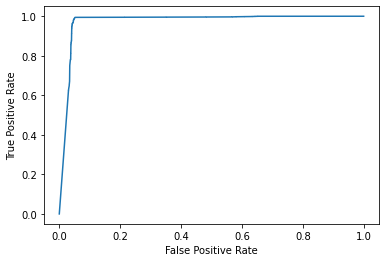

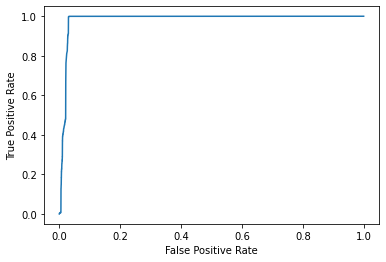

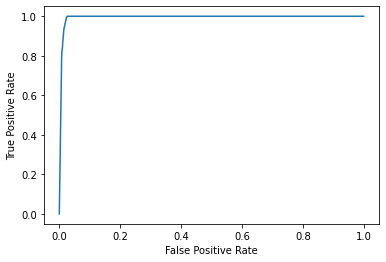

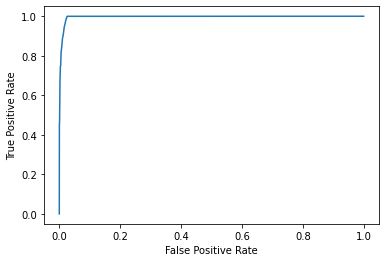

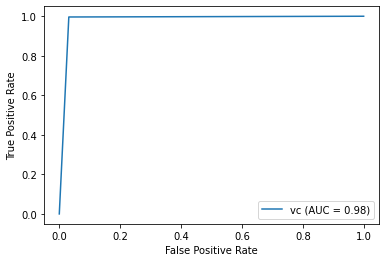

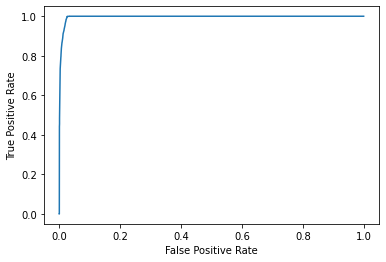

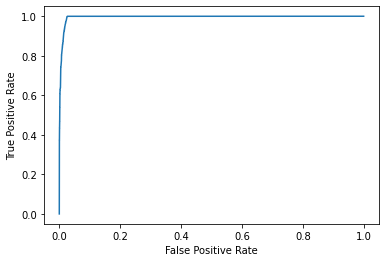

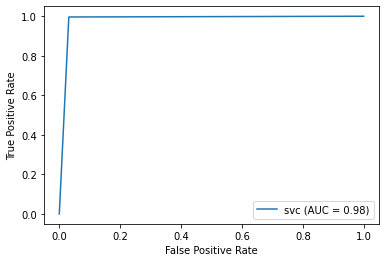

In [ ]:
select_k_result(7, x_rus, y_rus)

#### After balancing using RUS, and for selectKBest k = 8

Gaussian
[11006   615   140 11271]
Logistic Regression
[11248   373    54 11357]
RFC
[11341   280   121 11290]
XGB
[11312   309     4 11407]
ADC
[11296   325    30 11381]
MLPC
[11296   325    30 11381]
ID3
[11306   315    25 11386]
VC
[11236   385    52 11359]
SVC
[11238   383    53 11358]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.96722  |    0.948258 | 0.987731 |   0.967592 |      0.0387568 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.981461 |    0.968201 | 0.995268 |   0.981548 |      0.790174  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.982589 |    0.975799 | 0.989396 |   0

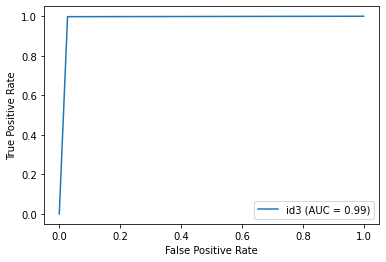

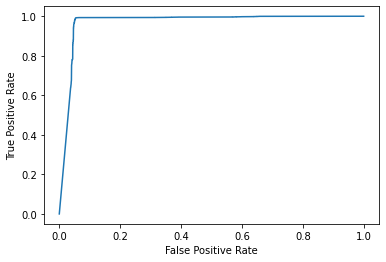

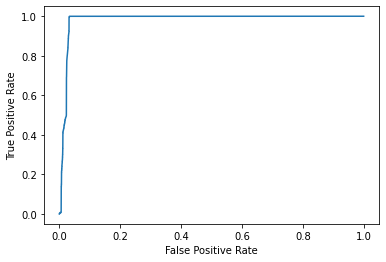

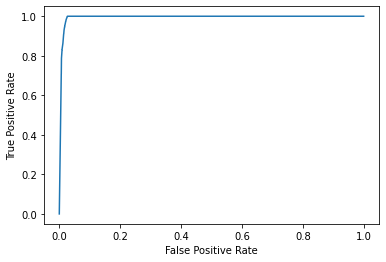

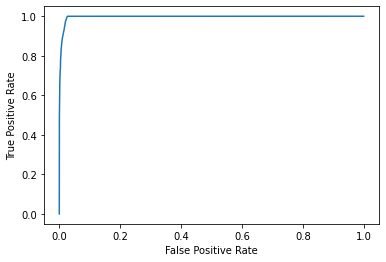

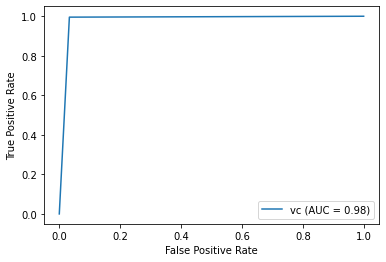

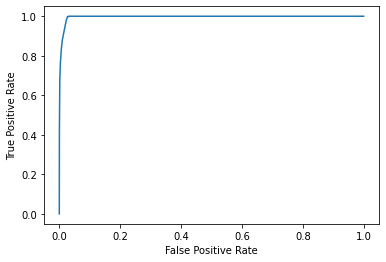

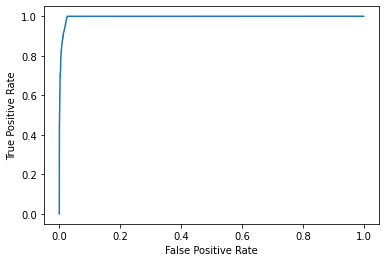

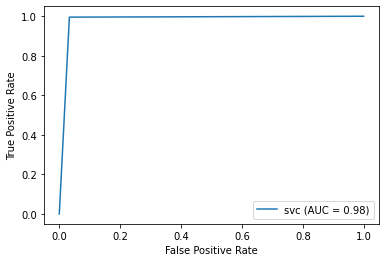

In [ ]:
select_k_result(8, x_rus, y_rus)

#### After balancing using RUS, and for selectKBest k = 9

Gaussian
[10832   619   120 11461]
Logistic Regression
[11075   376    46 11535]
RFC
[11169   282   104 11477]
XGB
[11131   320     1 11580]
ADC
[11115   336    21 11560]
MLPC
[11115   336    21 11560]
ID3
[11119   332     7 11574]
VC
[11066   385    43 11538]
SVC
[11066   385    47 11534]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.967914 |    0.948758 | 0.989638 |   0.968767 |      0.0459349 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.981678 |    0.968433 | 0.996028 |   0.982036 |      0.631097  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.983241 |    0.976018 | 0.99102  |   0

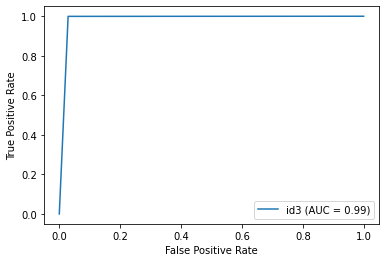

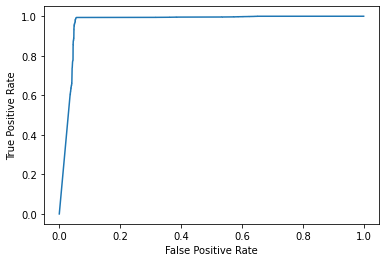

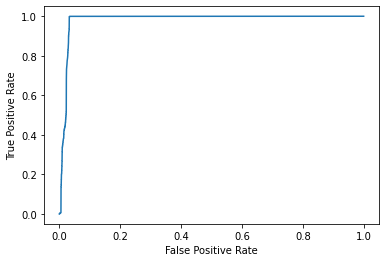

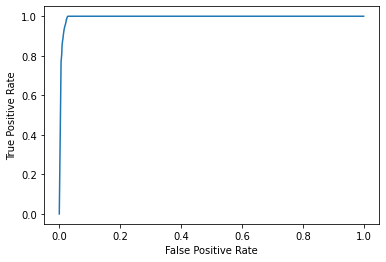

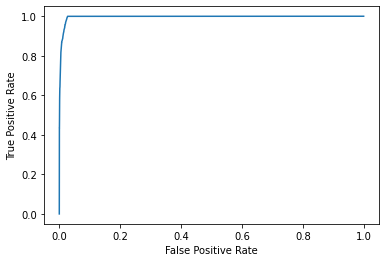

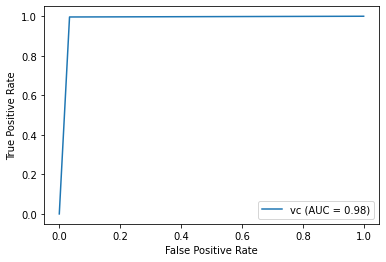

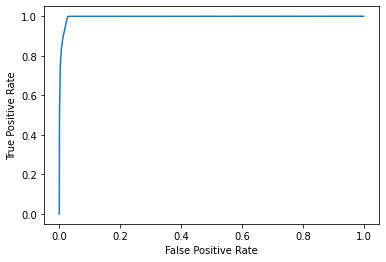

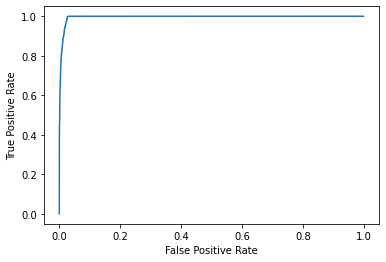

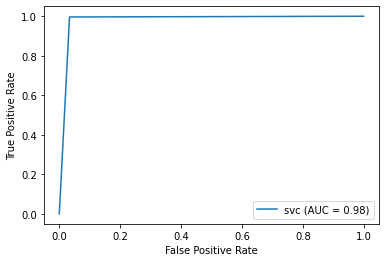

In [ ]:
select_k_result(9, x_rus, y_rus)

#### Bonus part: Using PCA on unsw-nb15 balanced(using RUS)  

In [ ]:
print(x_rus.shape,y_rus.shape,y_rus.value_counts())

(262818, 77) (262818, 1)  Label
0         131409
1         131409
dtype: int64


pca components =  6
Gaussian
[23129  3182   711 25542]
Logistic Regression
[23526  2785   654 25599]
RFC
[26248    63    61 26192]
XGB
[26113   198   148 26105]
ADC
[26049   262   177 26076]
MLPC
[26049   262   177 26076]
ID3
[26027   284   213 26040]
VC
[23524  2787   654 25599]
SVC
[23528  2783   654 25599]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.925938 |    0.889222 | 0.972917 |   0.929189 |      0.0773349 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.934575 |    0.901881 | 0.975089 |   0.937057 |      1.90145   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.997641 |    0.997

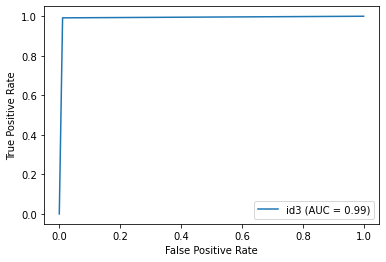

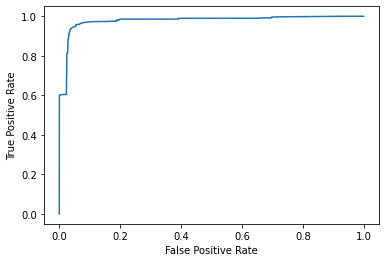

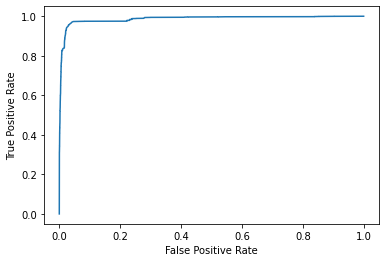

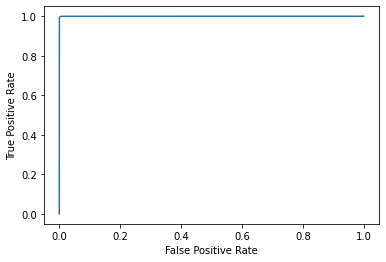

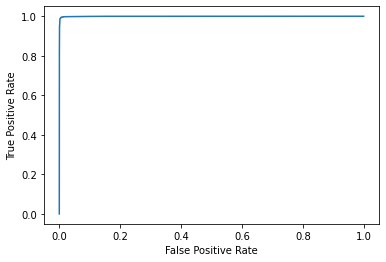

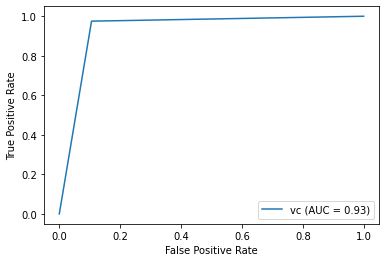

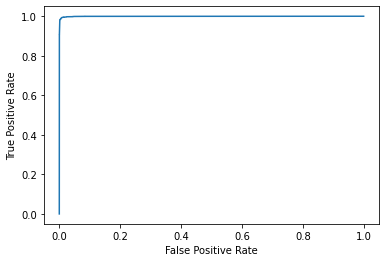

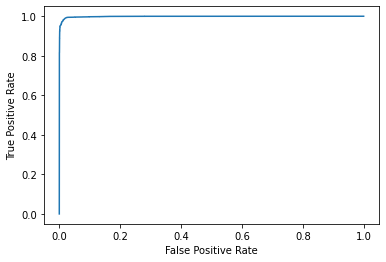

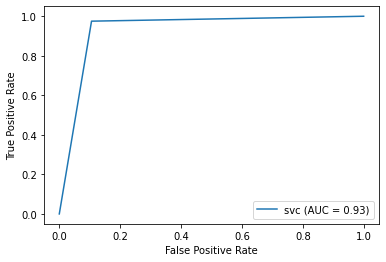

In [ ]:
show_pca_result(x_rus,y_rus,df_c)

### using Random over Sampling(ROS), on unsw-nb15:


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
print(X.shape)
print(Y.shape)

(774079, 40)
(774079, 1)


In [ ]:
ros = RandomOverSampler(random_state=42)
Y = Y.astype('int')
print( Y.value_counts() )
x_ros,y_ros = ros.fit_resample(X, Y)
print( y_ros.value_counts() )

Label
0        716499
1         57580
dtype: int64
Label
0        716499
1        716499
dtype: int64


#### After balancing using ROS, and for selectKBest k = 7

Gaussian
[135669   7715   1383 141833]
Logistic Regression
[138860   4524    576 142640]
RFC
[140920   2464     26 143190]
XGB
[139666   3718     96 143120]
ADC
[139515   3869    402 142814]
MLPC
[139515   3869    402 142814]
ID3
[139482   3902    289 142927]
VC
[138686   4698    555 142661]
SVC
[138692   4692    637 142579]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.968255 |    0.948411 | 0.990343 |   0.968924 |        0.34456 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.982205 |    0.969259 | 0.995978 |   0.982437 |        7.43199 |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

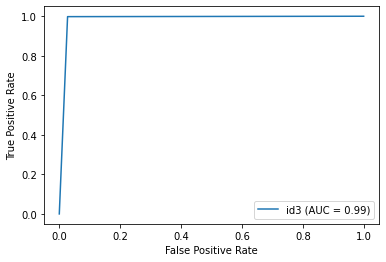

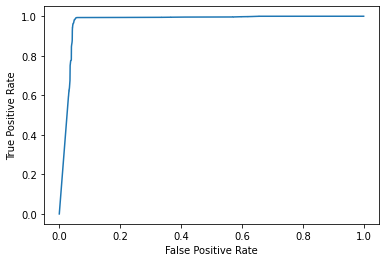

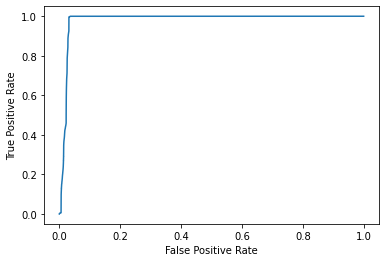

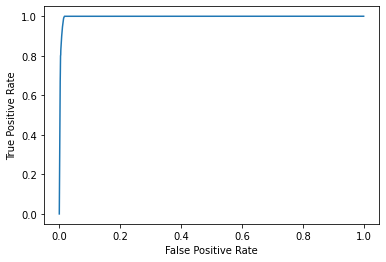

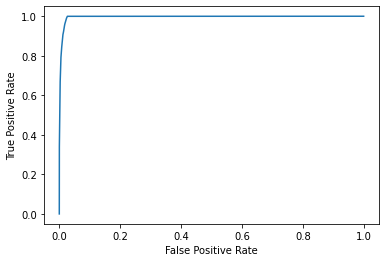

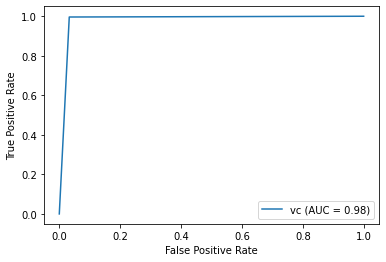

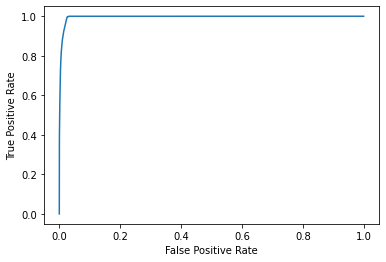

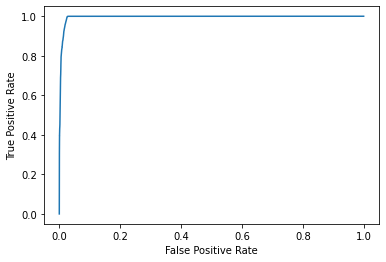

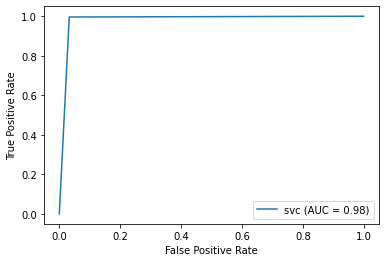

In [ ]:
select_k_result(7, x_ros, y_ros)

#### After balancing using ROS, and for selectKBest k = 8

Gaussian
[135711   7766   1535 141588]
Logistic Regression
[138868   4609    637 142486]
RFC
[141004   2473     35 143088]
XGB
[139660   3817     70 143053]
ADC
[139448   4029    346 142777]
MLPC
[139448   4029    346 142777]
ID3
[139530   3947    288 142835]
VC
[138693   4784    605 142518]
SVC
[138706   4771    682 142441]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.967547 |    0.948003 | 0.989275 |   0.968199 |       0.479182 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.981696 |    0.968667 | 0.995549 |   0.981924 |      13.289    |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

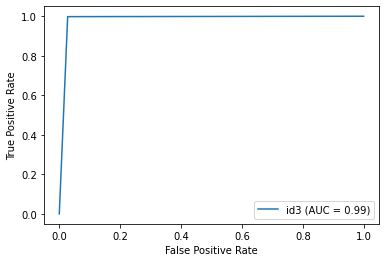

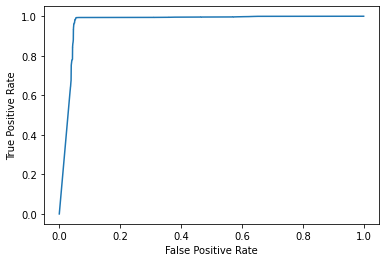

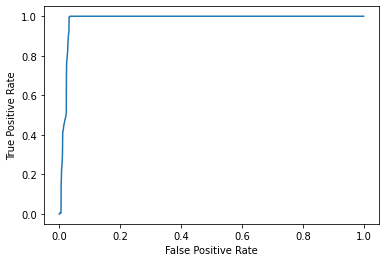

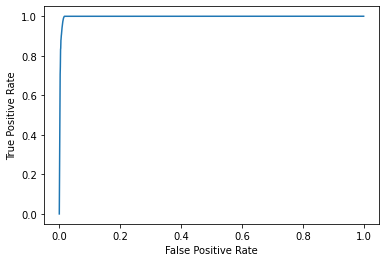

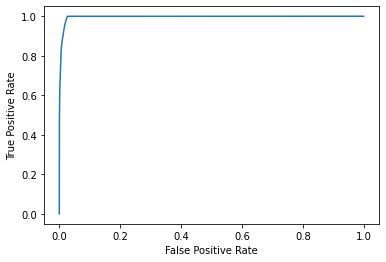

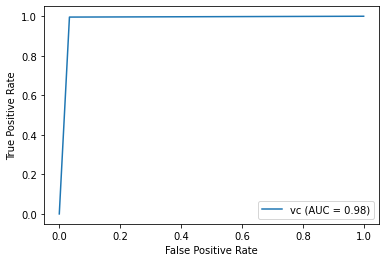

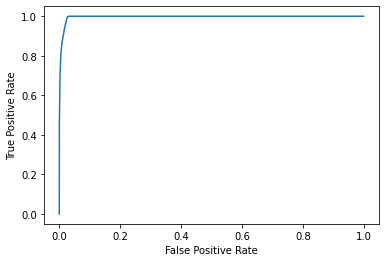

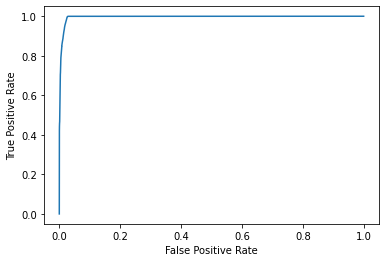

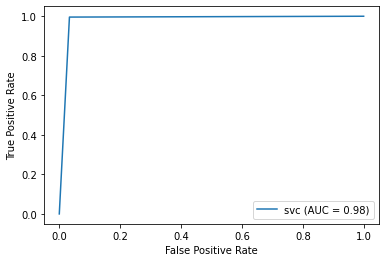

In [ ]:
select_k_result(8, x_ros, y_ros)

#### After balancing using ROS, and for selectKBest k = 9

Gaussian
[134934   7836   1652 142178]
Logistic Regression
[138229   4541    625 143205]
RFC
[140633   2137     17 143813]
XGB
[138951   3819     70 143760]
ADC
[138849   3921    381 143449]
MLPC
[138849   3921    381 143449]
ID3
[138812   3958     86 143744]
VC
[138038   4732    571 143259]
SVC
[138053   4717    657 143173]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.966895 |    0.947765 | 0.988514 |   0.967711 |       0.440443 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.981975 |    0.969265 | 0.995655 |   0.982282 |      14.6847   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

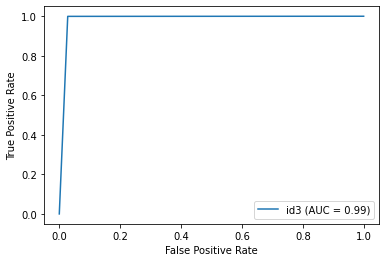

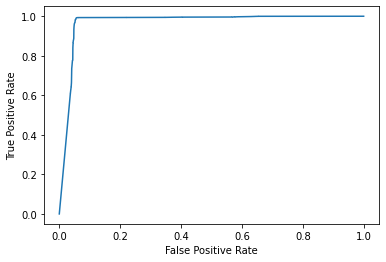

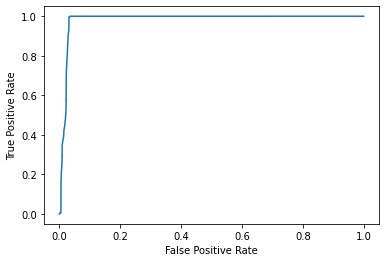

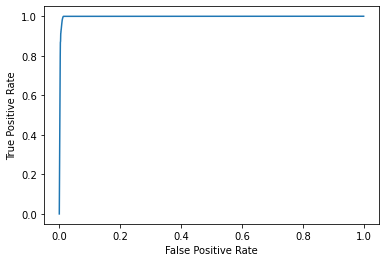

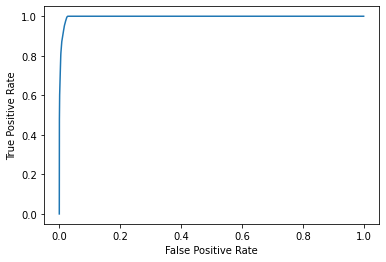

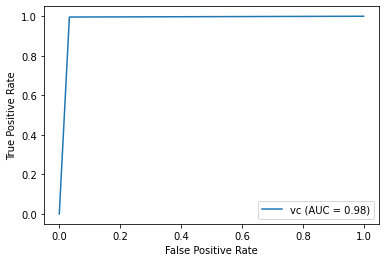

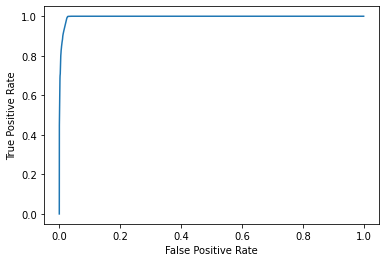

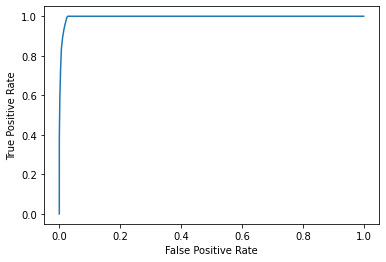

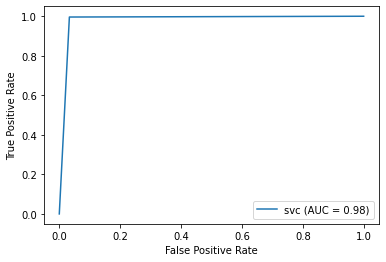

In [ ]:
select_k_result(9, x_ros, y_ros)

#### Bonus part: Using PCA on unsw-nb15 balanced(using ROS)  

In [ ]:
print(x_ros.shape, y_ros.shape, y_ros.value_counts())

(1432998, 40) (1432998, 1) Label
0        716499
1        716499
dtype: int64


pca components =  7
Gaussian
[137630   5489    346 143135]
Logistic Regression
[138204   4915    678 142803]
RFC
[140976   2143      0 143481]
XGB
[138882   4237     84 143397]
ADC
[138930   4189    368 143113]
MLPC
[138930   4189    368 143113]
ID3
[138761   4358    124 143357]
VC
[138204   4915    321 143160]
SVC
[138212   4907    321 143160]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.979641 |    0.963068 | 0.997589 |   0.980024 |       0.300645 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.980485 |    0.966727 | 0.995275 |   0.980793 |       3.77536  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC    

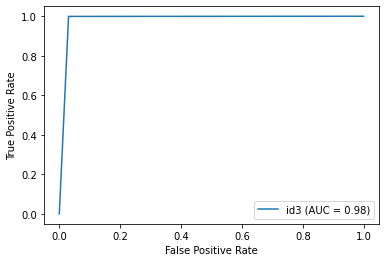

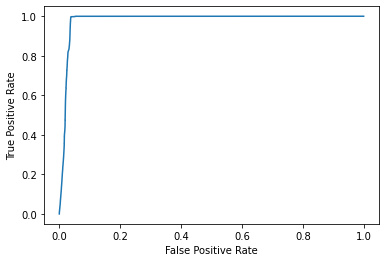

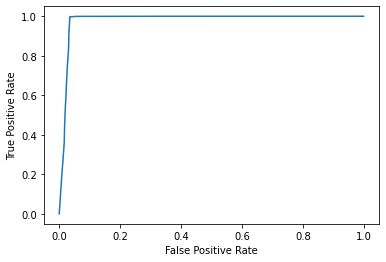

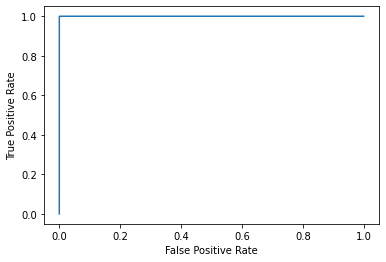

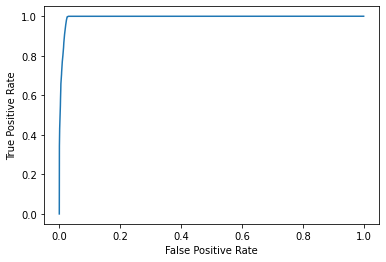

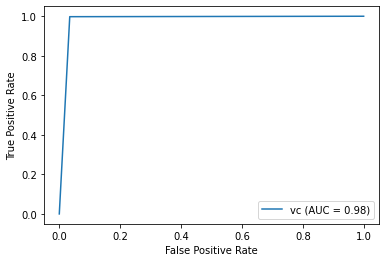

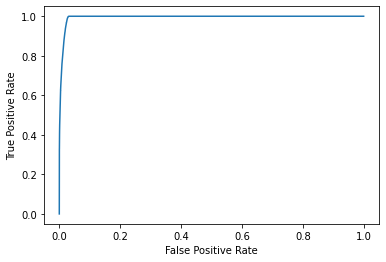

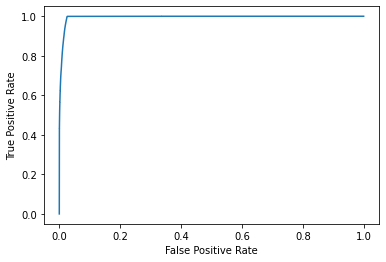

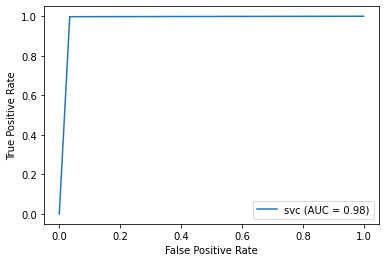

In [ ]:
show_pca_result(x_ros,y_ros,df_c)

### using SMOTE, on unsw-nb15:


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
print(X.shape,Y.shape)

(774079, 40) (774079, 1)


In [ ]:
sm = SMOTE(random_state=42)
Y = Y.astype('int')
print( Y.value_counts() )
x_sm, y_sm = sm.fit_resample(X, Y)
print( y_sm.value_counts() )

Label
0        716499
1         57580
dtype: int64
Label
0        716499
1        716499
dtype: int64


#### After balancing using SMOTE, and for selectKBest k = 7

Gaussian
[135378   7600   1255 142367]
Logistic Regression
[138462   4516    595 143027]
RFC
[140016   2962   1033 142589]
XGB
[139281   3697     87 143535]
ADC
[139037   3941    483 143139]
MLPC
[139037   3941    483 143139]
ID3
[139072   3906    384 143238]
VC
[138458   4520    470 143152]
SVC
[138463   4515    472 143150]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.969103 |    0.949322 | 0.991262 |   0.969839 |       0.468094 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.982167 |    0.969392 | 0.995857 |   0.982446 |       7.17708  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

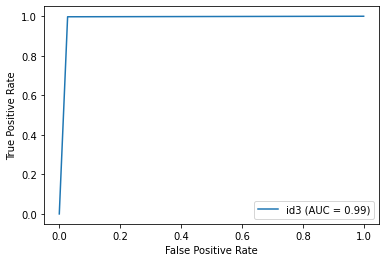

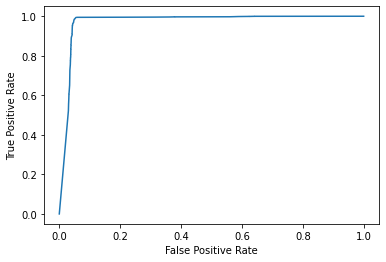

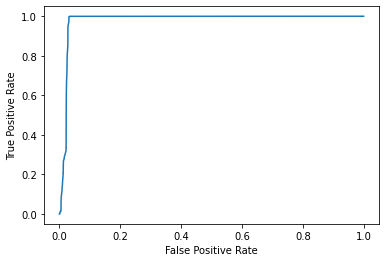

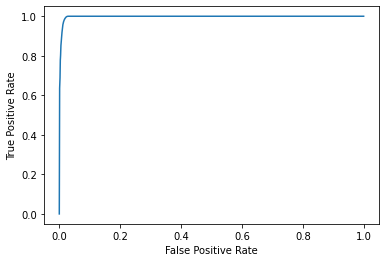

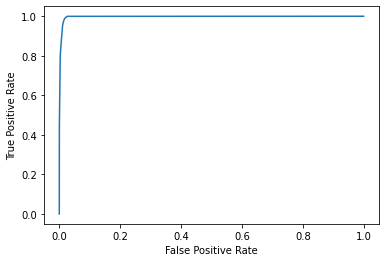

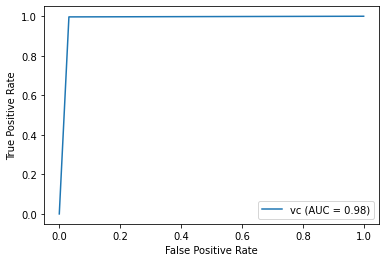

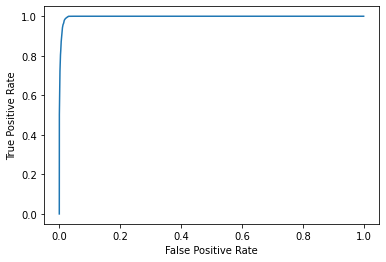

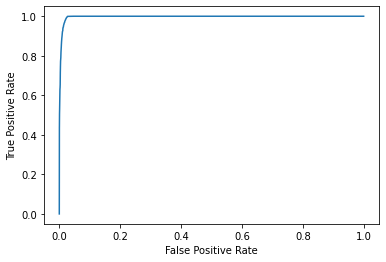

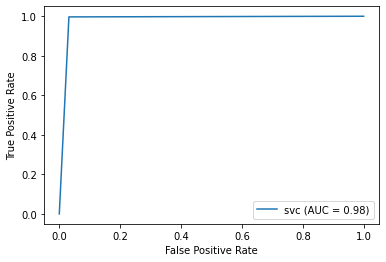

In [ ]:
select_k_result(7, x_sm, y_sm)

#### After balancing using SMOTE, and for selectKBest k = 8

Gaussian
[135677   7712   1469 141742]
Logistic Regression
[138911   4478    567 142644]
RFC
[140515   2874   1108 142103]
XGB
[139744   3645     88 143123]
ADC
[139568   3821    410 142801]
MLPC
[139568   3821    410 142801]
ID3
[139467   3922    307 142904]
VC
[138907   4482    467 142744]
SVC
[138916   4473    488 142723]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.967966 |    0.948399 | 0.989742 |   0.96863  |       0.341502 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.982397 |    0.969563 | 0.996041 |   0.982623 |      13.7992   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

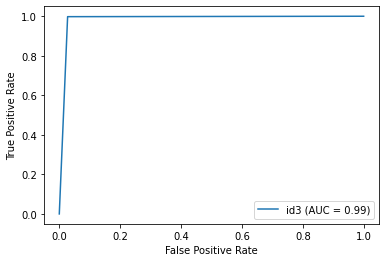

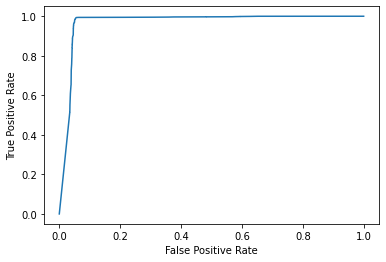

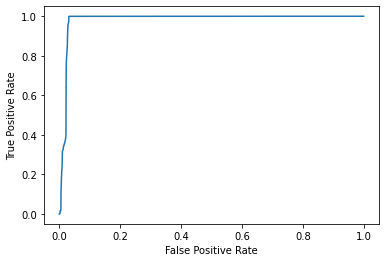

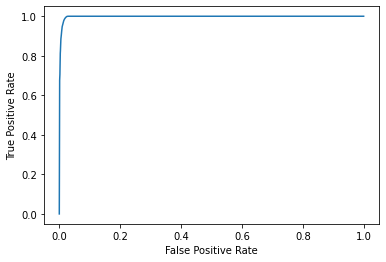

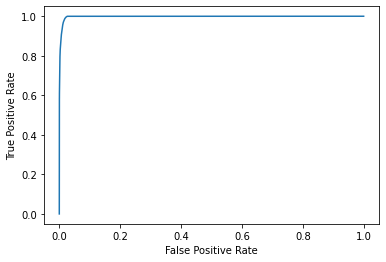

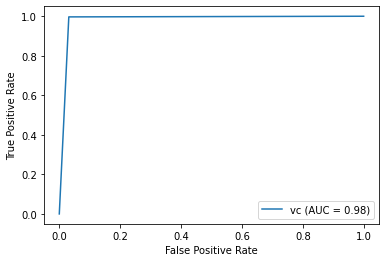

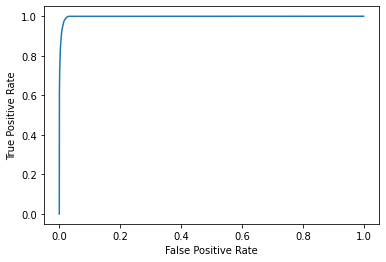

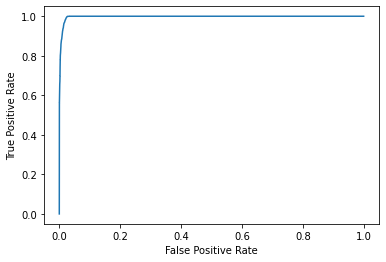

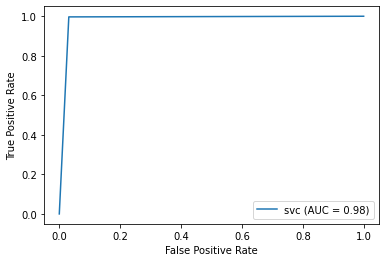

In [ ]:
select_k_result(8, x_sm, y_sm)

#### After balancing using SMOTE, and for selectKBest k = 9

Gaussian
[135669   7691   1485 141755]
Logistic Regression
[138845   4515    569 142671]
RFC
[140653   2707   1242 141998]
XGB
[139845   3515    159 143081]
ADC
[139616   3744    398 142842]
MLPC
[139616   3744    398 142842]
ID3
[139439   3921    215 143025]
VC
[138844   4516    478 142762]
SVC
[138856   4504    515 142725]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.967983 |    0.948537 | 0.989633 |   0.968649 |        0.43245 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.982261 |    0.969325 | 0.996028 |   0.982495 |       14.463   |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC                 |   0.9

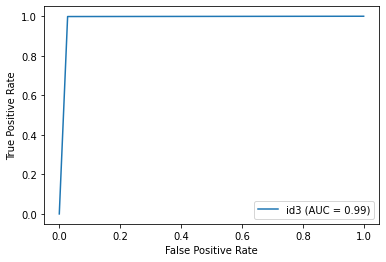

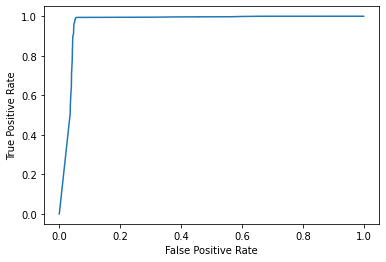

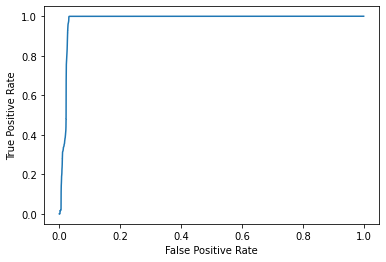

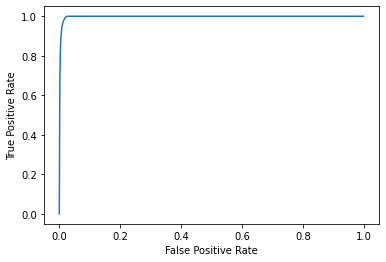

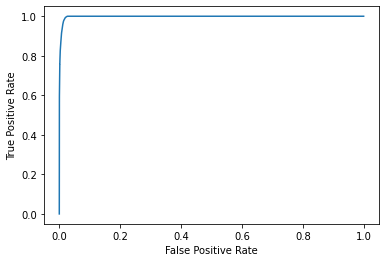

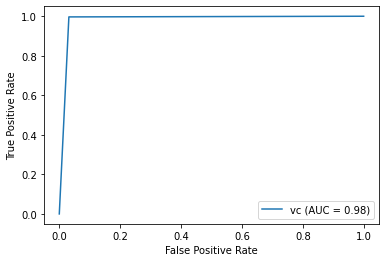

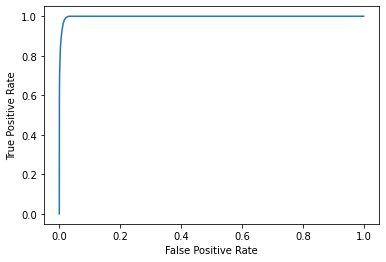

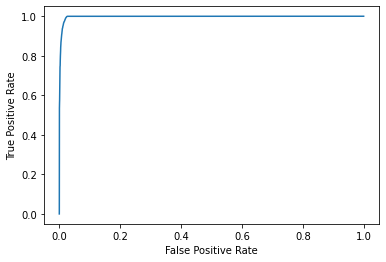

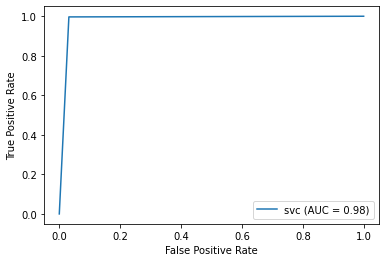

In [ ]:
select_k_result(9, x_sm, y_sm)

#### Bonus part: Using PCA on unsw-nb15 balanced(using SMOTE)  

In [ ]:
print(x_sm.shape, y_sm.shape, y_sm.value_counts())

(1432998, 40) (1432998, 1) Label
0        716499
1        716499
dtype: int64


pca components =  7
Gaussian
[137643   5422    417 143118]
Logistic Regression
[138099   4966    698 142837]
RFC
[139948   3117    203 143332]
XGB
[138747   4318     94 143441]
ADC
[138777   4288    214 143321]
MLPC
[138777   4288    214 143321]
ID3
[138729   4336    215 143320]
VC
[138099   4966    310 143225]
SVC
[138100   4965    303 143232]
+---------------------+------------+-------------+----------+------------+----------------+
|                     |   Accuracy |   Precision |   Recall |   F1-score |   Running time |
+=====================+============+=============+==========+============+================+
| Gaussian            |   0.979627 |    0.963498 | 0.997095 |   0.980009 |       0.466142 |
+---------------------+------------+-------------+----------+------------+----------------+
| Logistic Regression |   0.980237 |    0.966401 | 0.995137 |   0.980559 |       6.50693  |
+---------------------+------------+-------------+----------+------------+----------------+
| RFC    

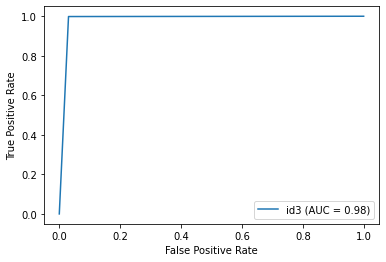

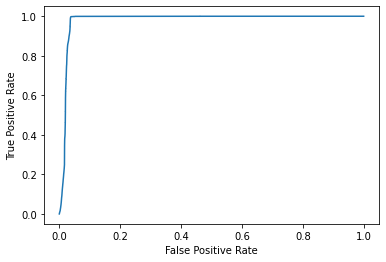

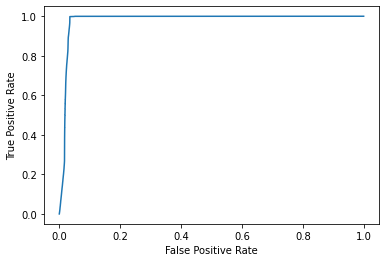

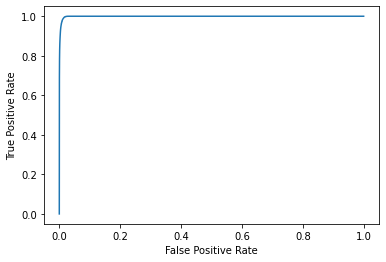

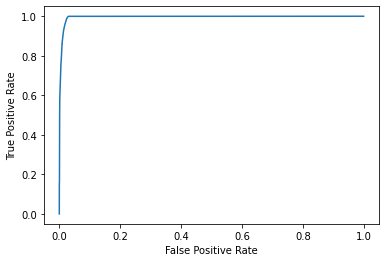

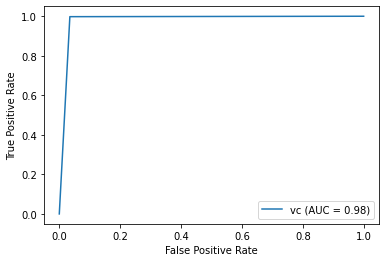

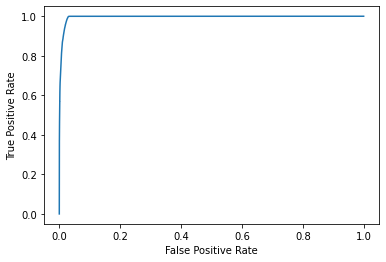

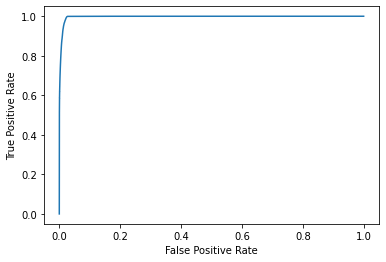

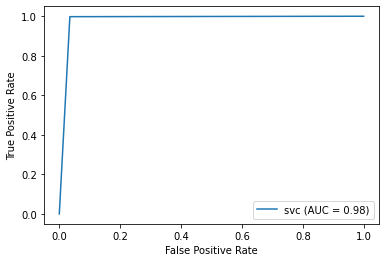

In [ ]:
show_pca_result(x_sm,y_sm,df_c)

#-------------------------------------------------------End Of unsw-nb15 dataset--------------------------------------------